<a href="https://colab.research.google.com/github/DigaoMesquita/python-recurrence-AVC-AprAVC/blob/main/AVC_uma_base_recorrencia_pt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modelo de previsão de AVC.**



# **Bibliotecas e CSV**


Instalando algumas bibliotecas que não são default do COLAB

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.1 MB/s eta 0:00:00


Importando as blibliotecas

In [ ]:
import pandas as pd
import numpy as np
import time
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, RandomUnderSampler, NearMiss, OneSidedSelection
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,ConfusionMatrixDisplay,precision_score,recall_score,r2_score,f1_score,classification_report,roc_curve,auc,precision_recall_curve,average_precision_score
#from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,ConfusionMatrixDisplay,precision_score,recall_score,r2_score,f1_score,classification_report,roc_curve,auc,precision_recall_curve,plot_precision_recall_curve,average_precision_score
#from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
#from sklearn.metrics import plot_roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

Lendo o CSV

In [ ]:
#data=pd.read_csv('cruz-bs_liga-bs_amer_trei.csv')
#data=pd.read_csv('mods-h20.csv')
#data=pd.read_csv('base-americana-treino-train_ig_0_e_1.csv')
#data=pd.read_csv('base_americana-healthcare-stroke_ig_0_e_1.csv')
#data=pd.read_csv('base_americana-healthcare-stroke_ig_num.csv')
data=pd.read_csv('base_cruzada_liga_hgf_popularCSVpt.csv')

In [ ]:
#O ID nada mais é do que um número único atribuído a cada paciente para controlá-los e torná-los únicos.
#Não há necessidade de ID, é totalmente inútil, então vamos removê-lo.
data.drop("id",inplace=True,axis=1)

In [ ]:
len(data)

713

In [ ]:
data.head()

,sexo,idade,hipertensao,cardiaco,estado_civil,tipo_trabalho,tipo_residencia,diabetes,imc,status_fumo,status_alcool,depressao_ansiedade,avc1,avc2
0,feminino,70.0,1,1,solteiro,aposentado,urbano,1.0,NaN,nunca fumou,nunca bebeu,0,1,0
1,masculino,59.0,0,0,solteiro,aposentado,rural,1.0,NaN,nunca fumou,nunca bebeu,0,1,0
2,feminino,66.0,1,1,casado,aposentado,urbano,1.0,NaN,nunca fumou,nunca bebeu,0,1,0
3,masculino,72.0,1,1,casado,aposentado,urbano,0.0,NaN,nunca fumou,nunca bebeu,0,1,0
4,masculino,39.0,0,0,casado,privado,urbano,0.0,NaN,nunca fumou,nunca bebeu,0,1,0


In [ ]:
data.sample(10)

,sexo,idade,hipertensao,cardiaco,estado_civil,tipo_trabalho,tipo_residencia,diabetes,imc,status_fumo,status_alcool,depressao_ansiedade,avc1,avc2
34,masculino,59.0,1,0,solteiro,desempregado,urbano,0.0,NaN,nunca fumou,nunca bebeu,0,1,0
173,masculino,44.0,1,0,casado,autonomo,urbano,0.0,23.0,nunca fumou,nunca bebeu,1,1,0
321,feminino,24.0,0,0,solteiro,privado,urbano,0.0,23.0,nunca fumou,alcoolotra,1,0,0
687,masculino,24.0,0,0,solteiro,privado,urbano,0.0,40.0,fumante,alcoolotra,0,0,0
609,masculino,41.0,0,0,casado,privado,urbano,0.0,26.0,nunca fumou,nunca bebeu,0,0,0
499,feminino,33.0,0,0,divorciado,privado,urbano,0.0,25.0,nunca fumou,alcoolotra,0,0,0
532,feminino,42.0,0,0,casado,casa,rural,0.0,25.0,nunca fumou,nunca bebeu,0,0,0
309,masculino,47.0,0,0,casado,privado,urbano,0.0,27.0,nunca fumou,nunca bebeu,0,0,0
36,feminino,42.0,0,0,casado,casa,urbano,0.0,NaN,nunca fumou,nunca bebeu,1,1,0
555,masculino,28.0,0,0,casado,autonomo,rural,0.0,29.0,nunca fumou,alcoolotra,0,0,0


In [ ]:
data.columns

Index(['sexo', 'idade', 'hipertensao', 'cardiaco', 'estado_civil',
       'tipo_trabalho', 'tipo_residencia', 'diabetes', 'imc', 'status_fumo',
       'status_alcool', 'depressao_ansiedade', 'avc1', 'avc2'],
      dtype='object')

In [ ]:
data.values

array([['feminino', 70.0, 1, ..., 0, 1, 0],
       ['masculino', 59.0, 0, ..., 0, 1, 0],
       ['feminino', 66.0, 1, ..., 0, 1, 0],
       ...,
       ['feminino', 37.0, 0, ..., 0, 0, 0],
       ['feminino', 35.0, 0, ..., 0, 0, 0],
       ['masculino', 50.0, 0, ..., 0, 1, 0]], dtype=object)

In [ ]:
unique_counts = pd.DataFrame.from_records([(col, data[col].nunique()) for col in data.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])

In [ ]:
unique_counts

,Column_Name,Num_Unique
0,sexo,2
2,hipertensao,2
3,cardiaco,2
6,tipo_residencia,2
7,diabetes,2
11,depressao_ansiedade,2
12,avc1,2
13,avc2,2
9,status_fumo,3
10,status_alcool,3


# **EDA**


A análise exploratória de dados (EDA) é uma ferramenta poderosa e simples que pode ser usada para melhorar sua compreensão de seus dados, explorando suas propriedades. A técnica é frequentemente aplicada quando o objetivo é criar novas hipóteses ou encontrar padrões nos dados. É frequentemente usado em grandes quantidades de dados qualitativos ou quantitativos que não foram analisados ​​antes. É uma das tecnicas da engenharia de recursos.

**Sexo**

Este atributo indica o sexo do paciente. Vamos ver como o gênero afeta e uma comparação inteligente da taxa de AVC.

Unique values
 ['feminino' 'masculino']
Value Counts
 feminino     358
masculino    355
Name: sexo, dtype: int64


<Axes: xlabel='sexo', ylabel='count'>

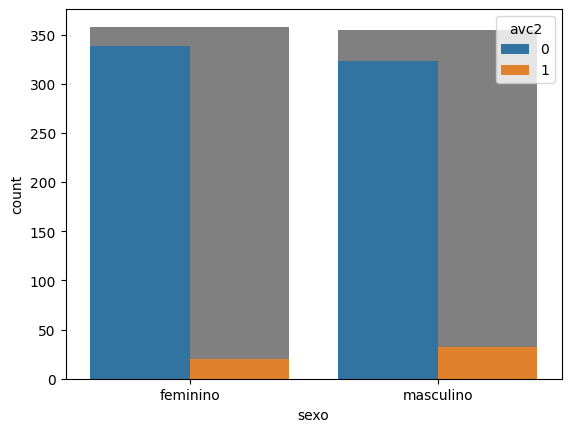

In [ ]:
print('Unique values\n',data['sexo'].unique())
print('Value Counts\n',data['sexo'].value_counts())
# Os códigos acima nos ajudarão a nos fornecer informações sobre seus valores exclusivos e a contagem de cada valor.
sns.countplot(data=data,x='sexo',color='gray')
# Ajuda a traçar um gráfico de contagem que nos ajudará a ver a contagem de valores em cada categoria única.
sns.countplot(data=data,x='sexo',hue='avc2')
# Este gráfico ajudará a analisar como o gênero afetará as chances do 2° acidente vascular cerebral.

**Idade**

Bem, aqui a idade não é apenas um número, é um dos significantes ou, como podemos dizer, é um fator muito importante. Vamos analisar nossos dados e ver quanto impacto tem o impacto real.

<Axes: xlabel='avc2', ylabel='idade'>

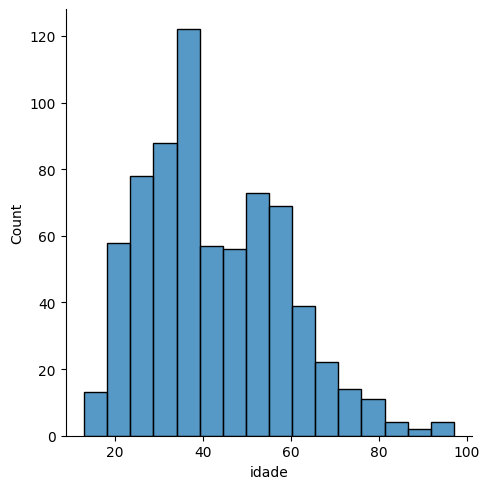

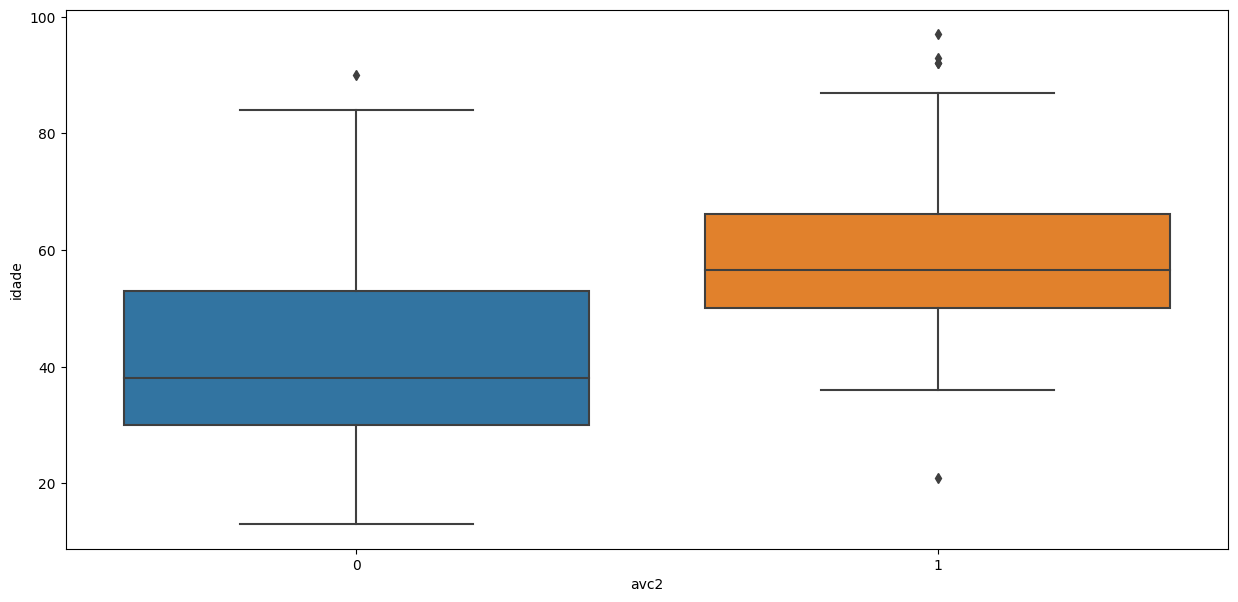

In [ ]:
data['idade'].nunique()
# Retorna o número de valores únicos neste atributo
sns.displot(data['idade'])
# Isso representará um gráfico de distribuição de idade variável
plt.figure(figsize=(15,7))
sns.boxplot(data=data,x='avc2',y='idade')
# O código acima representará um gráfico de caixa de idade variável em relação ao traço do atributo alvo

Número de valores únicos:

**Hipertensão**

A hipertensão é uma condição em que uma pessoa tem pressão alta. A hipertensão pode resultar em um acidente vascular cerebral. Vamos ver como acontece.

<Axes: xlabel='avc2', ylabel='idade'>

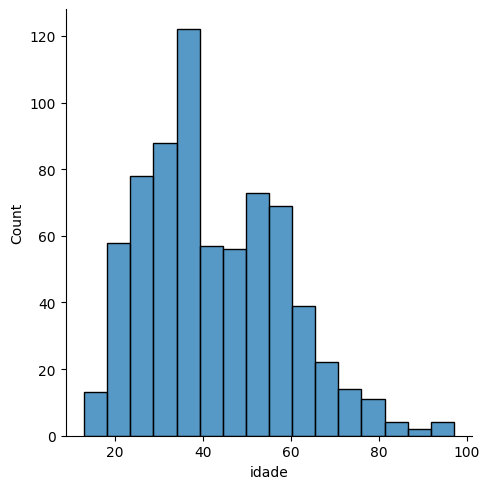

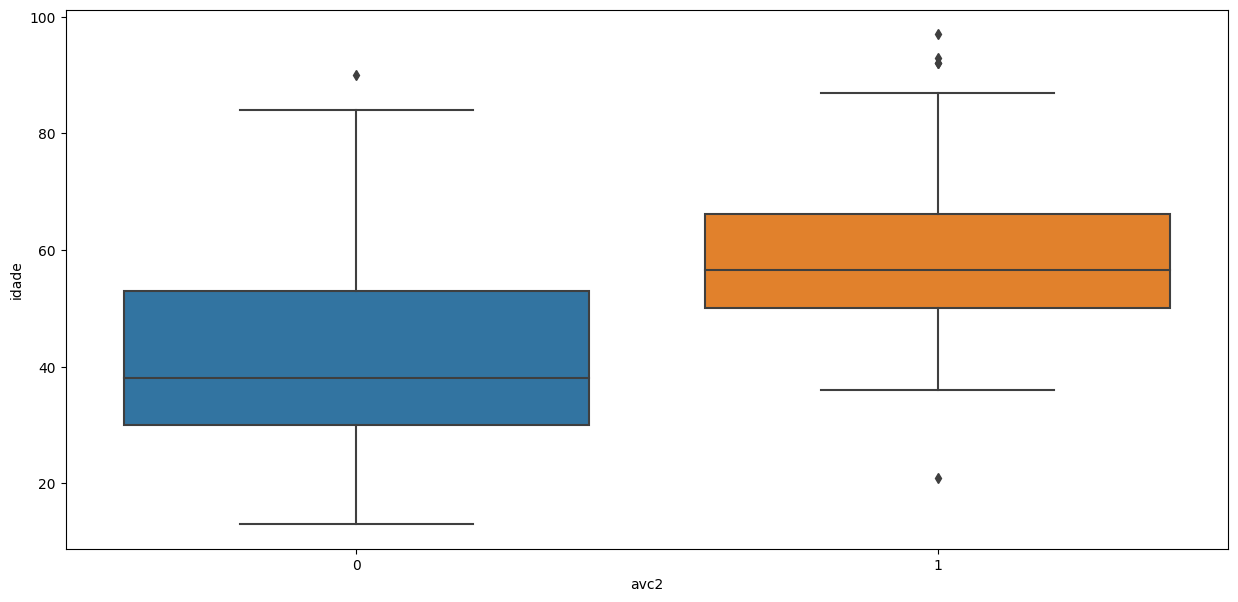

In [ ]:
data['idade'].nunique()
# Retorna o número de valores únicos neste atributo
sns.displot(data['idade'])
# Isso representará um gráfico de distribuição de idade variável
plt.figure(figsize=(15,7))
sns.boxplot(data=data,x='avc2',y='idade')
# O código acima representará um gráfico de caixa de idade variável em relação ao traço do atributo alvo

Unique Value
 [1 0]
Value Counts
 0    475
1    238
Name: hipertensao, dtype: int64


<Axes: xlabel='hipertensao', ylabel='count'>

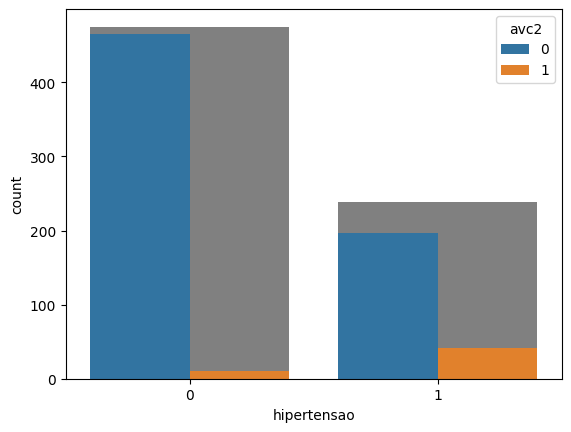

In [ ]:
print('Unique Value\n',data['hipertensao'].unique())
print('Value Counts\n',data['hipertensao'].value_counts())
# O código acima retornará um valor único para o atributo de doença cardíaca e suas contagens de valor

sns.countplot(data=data,x='hipertensao',color='gray')
sns.countplot(data=data,x='hipertensao',hue='avc2')

**Doença cardíaca**

Pessoas com doenças cardíacas tendem a ter um risco maior de sofrer um derrame se os cuidados adequados não forem tomados.

Unique Value
 [1 0]
Value Counts
 0    602
1    111
Name: cardiaco, dtype: int64


<Axes: xlabel='cardiaco', ylabel='count'>

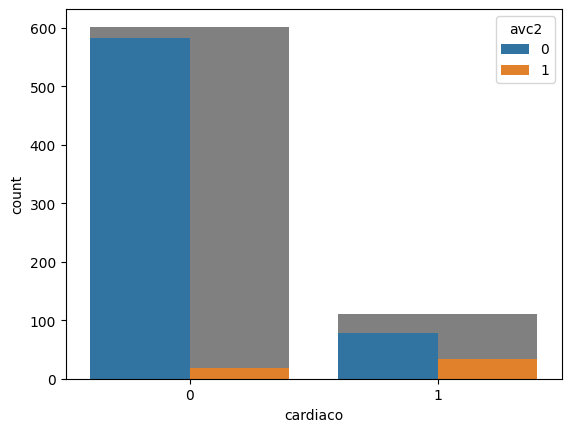

In [ ]:
print('Unique Value\n',data['cardiaco'].unique())
print('Value Counts\n',data['cardiaco'].value_counts())
# O código acima retornará um valor único para o atributo de doença cardíaca e suas contagens de valor

sns.countplot(data=data,x='cardiaco', color='gray')
sns.countplot(data=data,x='cardiaco',hue='avc2')
#Representará um gráfico de contador de doenças cardíacas variáveis

**Já casado**

Esse atributo nos dirá se o paciente já foi casado ou não. Vamos ver como isso afetará as chances de ter um derrame.

Unique Values
 ['solteiro' 'casado' 'viuvo' 'divorciado' 'outro']
Value Counts
 casado        389
solteiro      225
divorciado     55
outro          24
viuvo          20
Name: estado_civil, dtype: int64


<Axes: xlabel='estado_civil', ylabel='count'>

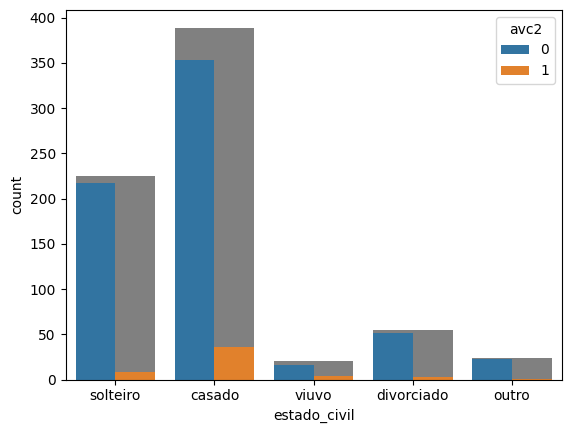

In [ ]:
print('Unique Values\n',data['estado_civil'].unique())
print('Value Counts\n',data['estado_civil'].value_counts())
# O código acima nos mostrará valores únicos de número de atributo e sua contagem sns.countplot (data = data, x = 'ever_married')
sns.countplot(data=data,x='estado_civil',color='gray')
# Trama contrária do atributo já casado
sns.countplot(data=data,x='estado_civil',hue='avc2')
# Já casado com respeito ao 2° AVC

**Tipo de trabalho**

Este atributo contém dados sobre o tipo de trabalho que o paciente realiza. Diferentes tipos de trabalho têm diferentes tipos de problemas e desafios que podem ser a possível razão para excitação, emoção, estresse, etc. O estresse nunca é bom para a saúde, vamos ver como essa variável pode afetar as chances de ter um derrame.

Unique Value
 ['aposentado' 'privado' 'casa' 'desempregado' 'autonomo' 'publico' 'outro']
Value Counts
 privado         331
autonomo        135
publico          70
aposentado       62
casa             54
desempregado     53
outro             8
Name: tipo_trabalho, dtype: int64


<Axes: xlabel='tipo_trabalho', ylabel='count'>

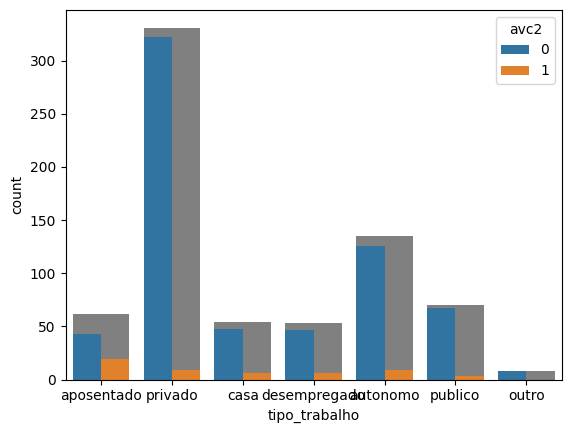

In [ ]:
print('Unique Value\n',data['tipo_trabalho'].unique())
print('Value Counts\n',data['tipo_trabalho'].value_counts())
# O código acima retornará valores únicos de atributos e sua contagem
sns.countplot(data=data,x='tipo_trabalho', color='gray')
# O código acima irá criar um gráfico de contagem
sns.countplot(data=data,x='tipo_trabalho',hue='avc2')
# O código acima criará um gráfico de contagem em relação ao traço

**Tipo de Residência**

Este atributo nos diz se em que tipo de residência o paciente está. Pode ser Urbano ou Rural.

Unique Values
 ['urbano' 'rural']
Value Counts
 urbano    575
rural     138
Name: tipo_residencia, dtype: int64


<Axes: xlabel='tipo_residencia', ylabel='count'>

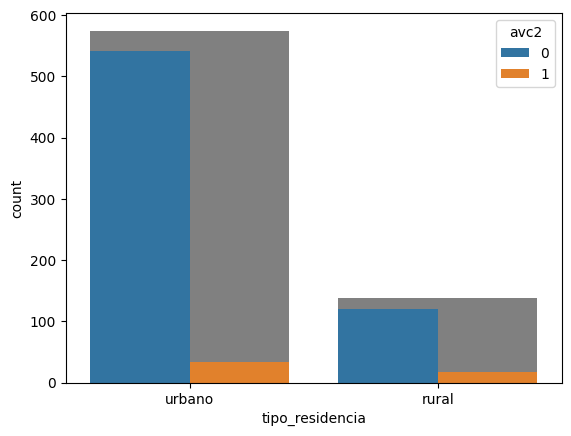

In [ ]:
print('Unique Values\n',data['tipo_residencia'].unique())
print("Value Counts\n",data['tipo_residencia'].value_counts())
# O código acima retornará valores únicos da variável e sua contagem
sns.countplot(data=data,x='tipo_residencia',color='gray')
# Isso criará um gráfico de contador
sns.countplot(data=data,x='tipo_residencia',hue='avc2')
# Tipo de residência em relação ao 2° AVC

**Diabetes**

Informa se o paciente possui diabetes

Unique Value
 [ 1.  0. nan]
Value Counts
 0.0    599
1.0     95
Name: diabetes, dtype: int64


<Axes: xlabel='diabetes', ylabel='count'>

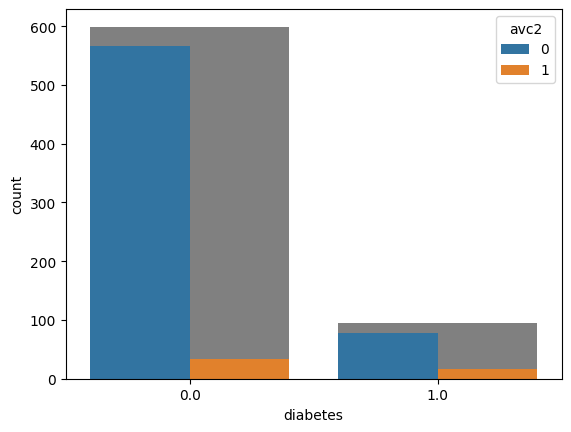

In [ ]:
print('Unique Value\n',data['diabetes'].unique())
print('Value Counts\n',data['diabetes'].value_counts())
# O código acima retornará um valor único para o atributo de diabetes e suas contagens de valor
sns.countplot(data=data,x='diabetes',color='gray')
sns.countplot(data=data,x='diabetes',hue='avc2')
#Avg_glucose_level e 2° AVC

**IMC**

O Índice de Massa Corporal é uma medida de gordura corporal baseada na altura e no peso que se aplica a homens e mulheres adultos. Vamos ver como isso afeta as chances de ter um derrame.

<Axes: xlabel='avc2', ylabel='imc'>

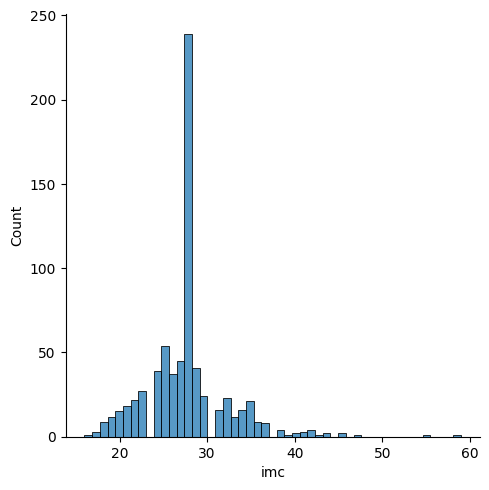

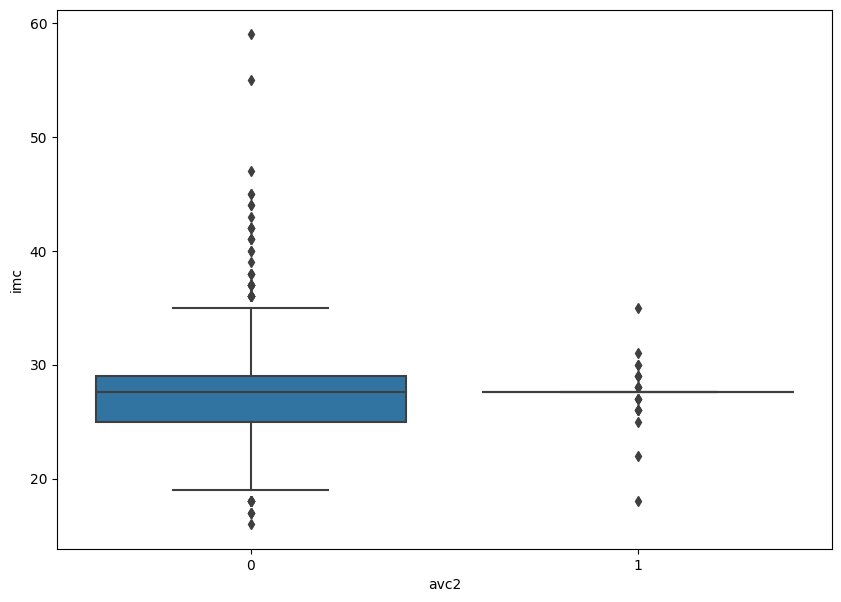

In [ ]:
# Retorna um número de valores nulos
data['imc'].isna().sum()
# Preenchendo valores nulos com valor médio
data['imc'].fillna(data['imc'].mean(),inplace=True)
# Retorna o número de valores únicos nesse atributo
data['imc'].nunique()
# Distribuição de imc
sns.displot(data['imc'])
# IMC em relação ao 2° AVC
plt.figure(figsize=(10,7))
sns.boxplot(data=data,x='avc2',y='imc',)


**Condição de fumante**

Esses atributos nos dizem se o paciente fuma ou não. Fumar é prejudicial à saúde e pode causar doenças cardíacas. Vamos ver como fica no caso de nossos dados.

Unique Values
 ['nunca fumou' 'fumante' 'ex fumante']
Value Counts
 nunca fumou    579
ex fumante      76
fumante         58
Name: status_fumo, dtype: int64


<Axes: xlabel='status_fumo', ylabel='count'>

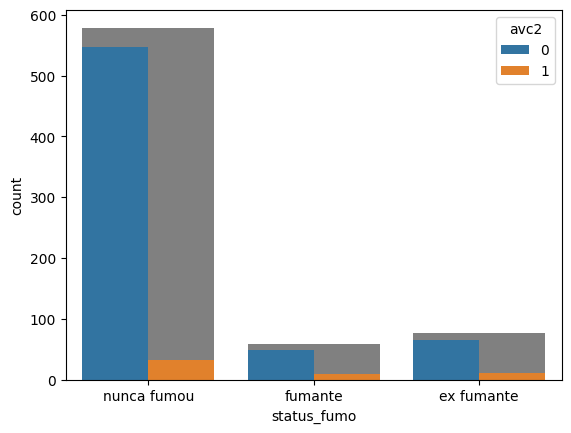

In [ ]:
print('Unique Values\n',data['status_fumo'].unique())
print('Value Counts\n',data['status_fumo'].value_counts())
# Retorna valores únicos e sua contagem
sns.countplot(data=data,x='status_fumo',color='gray')
# Gráfico de contagem do status de fumante
sns.countplot(data=data,x='status_fumo',hue='avc2')
# Status de fumante em relação ao 2° AVC

**Condição de etilista**

Esses atributos nos dizem se o paciente bebe ou não.

Unique Values
 ['nunca bebeu' 'alcoolotra' 'ex alcoolotra']
Value Counts
 nunca bebeu      312
alcoolotra       282
ex alcoolotra    119
Name: status_alcool, dtype: int64


<Axes: xlabel='status_alcool', ylabel='count'>

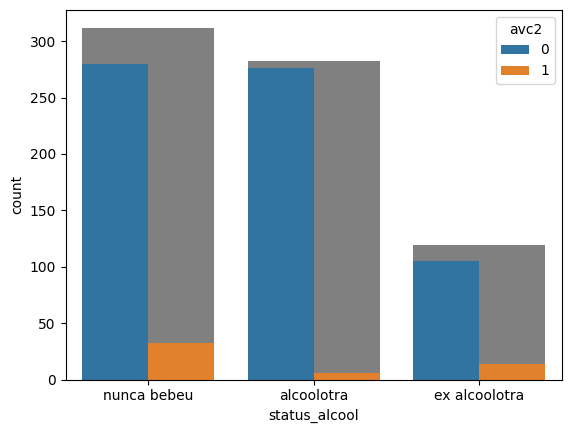

In [ ]:
print('Unique Values\n',data['status_alcool'].unique())
print('Value Counts\n',data['status_alcool'].value_counts())
# Retorna valores únicos e sua contagem
sns.countplot(data=data,x='status_alcool',color='gray')
# Gráfico de contagem do status de etilista
sns.countplot(data=data,x='status_alcool',hue='avc2')
# Status de etilista em relação ao 2° AVC

**Condição de depressão/ansiedade**

Esses atributos nos dizem se o paciente tem depressão/ansiedade.

Unique Values
 [0 1]
Value Counts
 0    477
1    236
Name: depressao_ansiedade, dtype: int64


<Axes: xlabel='depressao_ansiedade', ylabel='count'>

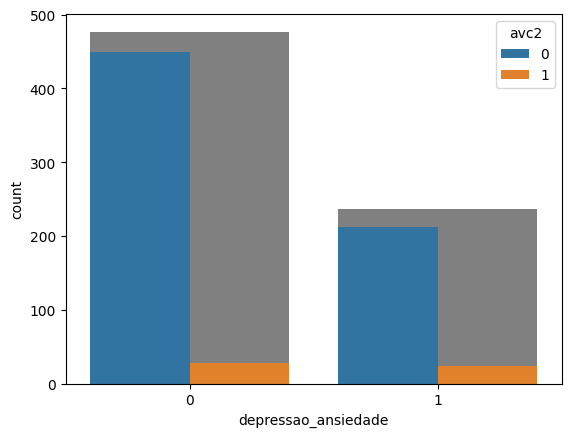

In [ ]:
print('Unique Values\n',data['depressao_ansiedade'].unique())
print('Value Counts\n',data['depressao_ansiedade'].value_counts())
# Retorna valores únicos e sua contagem
sns.countplot(data=data,x='depressao_ansiedade',color='gray')
# Gráfico de contagem do status de depressão_ansiedade
sns.countplot(data=data,x='depressao_ansiedade',hue='avc2')
# Status de depressão_ansiedade em relação ao 2° AVC

**Primeiro evento do AVC**

Pessoas que tiveram o primeiro evento tendem a ter um risco maior de sofrer um segundo derrame se os cuidados adequados não forem tomados.

Unique Value
 [1 0]
Value Counts
 0    465
1    248
Name: avc1, dtype: int64


<Axes: xlabel='avc1', ylabel='count'>

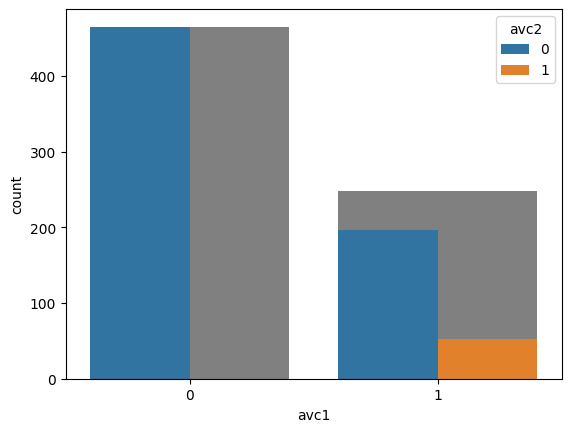

In [ ]:
print('Unique Value\n',data['avc1'].unique())
print('Value Counts\n',data['avc1'].value_counts())
# O código acima retornará um valor único para o atributo do 1° AVC e suas contagens de valor

sns.countplot(data=data,x='avc1', color='gray')
sns.countplot(data=data,x='avc1',hue='avc2')
#Representará um gráfico de contador do 1° AVC

**Recorrencia do AVC**

Nossa variável de destino. Ela nos diz se os pacientes têm chances de ter  derrame pela segunda vez.

Unique Value
 [0 1]
Value Counts
 0    661
1     52
Name: avc2, dtype: int64


<Axes: xlabel='avc2', ylabel='count'>

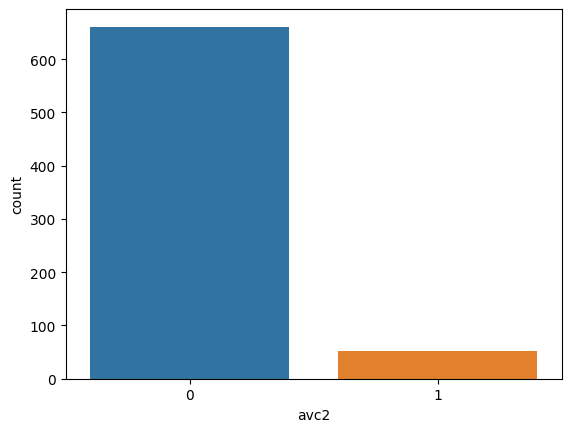

In [ ]:
print('Unique Value\n',data['avc2'].unique())
print('Value Counts\n',data['avc2'].value_counts())
# Retorna o valor único e sua contagem
sns.countplot(data=data,x='avc2')
# Plotagem de contagem do 2° AVC

# **Engenharia de Recursos**


**Codificação de rótulo**

Nosso conjunto de dados é uma mistura de dados categóricos e numéricos e, como os algoritmos de ML entendem os dados de natureza numérica, vamos codificar nossos dados categóricos em numéricos usando o Label Encoder. Label Encoder é uma técnica que converte dados categóricos em dados numéricos. Ele pega o valor em ordem crescente e o converte em dados numéricos de 0 a n-1.

In [ ]:
cols=data.select_dtypes(include=['object']).columns
print(cols)
# Este código buscará colunas cujo tipo de dados é objeto.
le=LabelEncoder()
# Inicializando nosso objeto Label Encoder

data[cols]=data[cols].apply(le.fit_transform)
# Transferência de dados categóricos para numéricos
print(data.head(10))

Index(['sexo', 'estado_civil', 'tipo_trabalho', 'tipo_residencia',
       'status_fumo', 'status_alcool'],
      dtype='object')
   sexo  idade  hipertensao  cardiaco  estado_civil  tipo_trabalho  \
0     0   70.0            1         1             3              0   
1     1   59.0            0         0             3              0   
2     0   66.0            1         1             0              0   
3     1   72.0            1         1             0              0   
4     1   39.0            0         0             0              5   
5     0   54.0            1         0             0              2   
6     0   56.0            1         0             3              5   
7     1   21.0            1         1             3              3   
8     0   57.0            1         0             4              0   
9     0   38.0            1         1             3              0   

   tipo_residencia  diabetes    imc  status_fumo  status_alcool  \
0                1       1.0  27.

In [ ]:
#data = data.dropna()#excluir todas as linhas do dataset por N/A
data = data.fillna(0)#transforma todos os N/A no dataset em 0
#data = data.replace(np.nan,1)#transforma todos os N/A no dataset em 1 ou qualquer numero que desejar.



In [ ]:
data.head

<bound method NDFrame.head of      sexo  idade  hipertensao  cardiaco  estado_civil  tipo_trabalho  \
0       0   70.0            1         1             3              0   
1       1   59.0            0         0             3              0   
2       0   66.0            1         1             0              0   
3       1   72.0            1         1             0              0   
4       1   39.0            0         0             0              5   
..    ...    ...          ...       ...           ...            ...   
708     1   24.0            0         0             3              5   
709     0   28.0            0         0             3              5   
710     0   37.0            0         0             1              5   
711     0   35.0            0         0             0              5   
712     1   50.0            0         0             0              5   

     tipo_residencia  diabetes    imc  status_fumo  status_alcool  \
0                  1       1.0  27.6

In [ ]:
colunas = data.columns
colunas

Index(['sexo', 'idade', 'hipertensao', 'cardiaco', 'estado_civil',
       'tipo_trabalho', 'tipo_residencia', 'diabetes', 'imc', 'status_fumo',
       'status_alcool', 'depressao_ansiedade', 'avc1', 'avc2'],
      dtype='object')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn import preprocessing


x = data.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
data = pd.DataFrame(x_scaled)

In [ ]:
data.columns = colunas

In [ ]:
data.head(30)

,sexo,idade,hipertensao,cardiaco,estado_civil,tipo_trabalho,tipo_residencia,diabetes,imc,status_fumo,status_alcool,depressao_ansiedade,avc1,avc2
0,0.0,0.721649,1.0,1.0,0.75,0.000000,1.0,1.0,0.270698,1.0,1.0,0.0,1.0,0.0
1,1.0,0.608247,0.0,0.0,0.75,0.000000,0.0,1.0,0.270698,1.0,1.0,0.0,1.0,0.0
2,0.0,0.680412,1.0,1.0,0.00,0.000000,1.0,1.0,0.270698,1.0,1.0,0.0,1.0,0.0
3,1.0,0.742268,1.0,1.0,0.00,0.000000,1.0,0.0,0.270698,1.0,1.0,0.0,1.0,0.0
4,1.0,0.402062,0.0,0.0,0.00,0.833333,1.0,0.0,0.270698,1.0,1.0,0.0,1.0,0.0
5,0.0,0.556701,1.0,0.0,0.00,0.333333,0.0,1.0,0.270698,0.5,1.0,1.0,1.0,0.0
6,0.0,0.577320,1.0,0.0,0.75,0.833333,1.0,1.0,0.270698,1.0,1.0,0.0,1.0,0.0
7,1.0,0.216495,1.0,1.0,0.75,0.500000,0.0,0.0,0.270698,1.0,1.0,0.0,1.0,1.0
8,0.0,0.587629,1.0,0.0,1.00,0.000000,0.0,1.0,0.270698,1.0,1.0,0.0,1.0,0.0
9,0.0,0.391753,1.0,1.0,0.75,0.000000,0.0,0.0,0.270698,1.0,1.0,1.0,1.0,1.0


**Correlação**

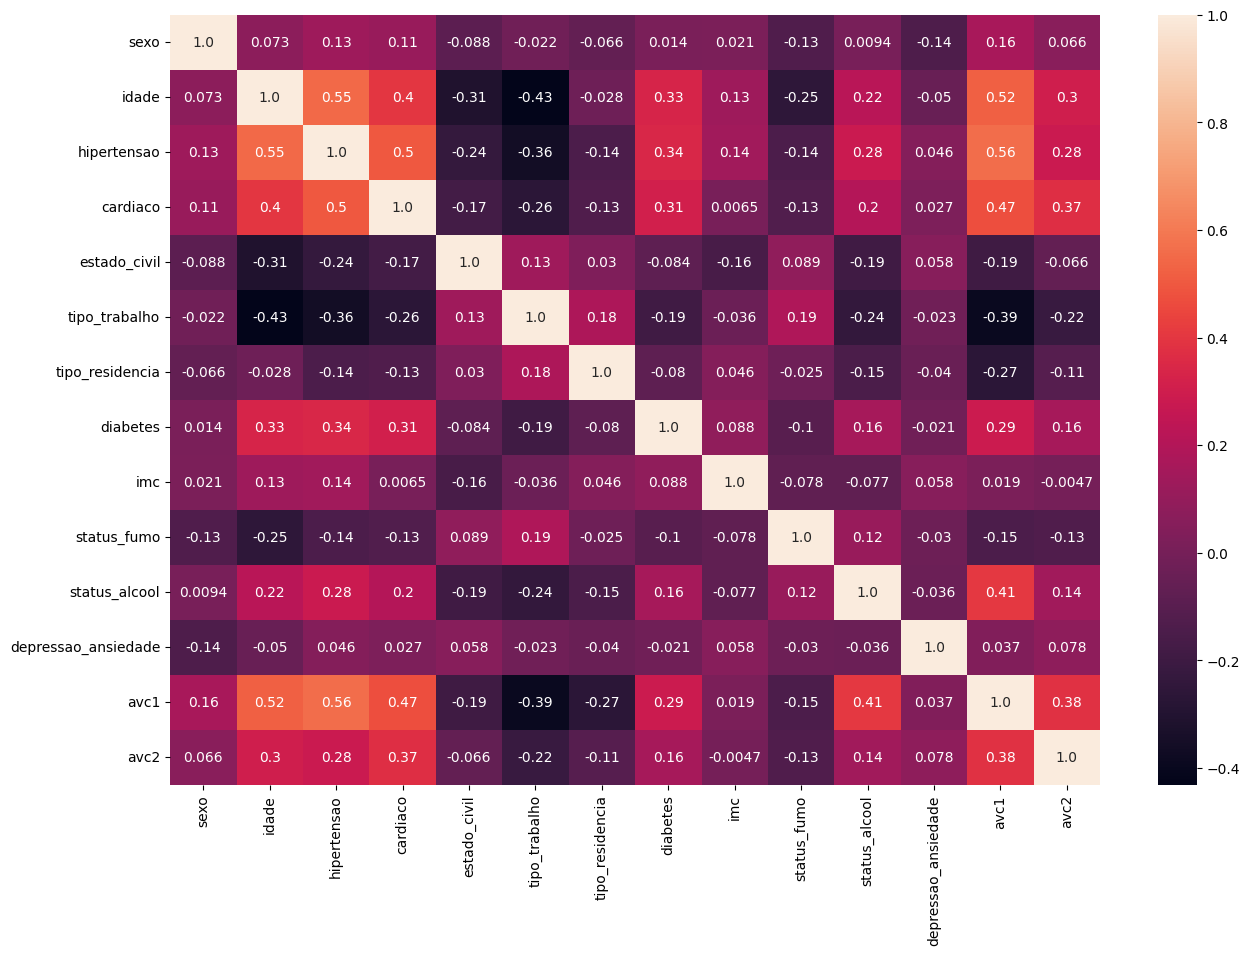

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(),annot=True,fmt='.2')
plt.savefig('matriz_correlacao.png')

Observação: As variáveis ​​que mostram alguma correlação efetiva são: idade, hipertensão, doença cardíaca, estado civil, diabetes e fumante . Por segurança, vamos verificar nossos recursos usando SelectKBest e F_Classif.

In [ ]:
#classifier = SelectKBest(score_func=f_classif,k=5)
classifier = SelectKBest(score_func=f_classif,k=8)
fits = classifier.fit(data.drop('avc2',axis=1),data['avc2'])
x=pd.DataFrame(fits.scores_)
columns = pd.DataFrame(data.drop('avc2',axis=1).columns)
fscores = pd.concat([columns,x],axis=1)
fscores.columns = ['Attribute','Score']
fscores.sort_values(by='Score',ascending=False)

,Attribute,Score
12,avc1,123.021295
3,cardiaco,113.139920
1,idade,71.552552
2,hipertensao,61.360395
5,tipo_trabalho,34.720504
7,diabetes,18.645097
10,status_alcool,14.394291
9,status_fumo,12.297098
6,tipo_residencia,8.444451
11,depressao_ansiedade,4.330743


No resultado acima, podemos ver que a idade é uma variável altamente correlacionada e então fica decrescente. Estou mantendo a pontuação limite em 10. Resultando nos mesmos recursos que obtivemos no mapa de calor.

In [ ]:
cols=fscores[fscores['Score']>10]['Attribute']
print(cols)

1             idade
2       hipertensao
3          cardiaco
5     tipo_trabalho
7          diabetes
9       status_fumo
10    status_alcool
12             avc1
Name: Attribute, dtype: object


# **Dividindo dados**

Agora, vamos dividir os recursos em conjuntos de treinamento e teste para treinar e testar nossos modelos de classificação.

In [ ]:
train_x,test_x,train_y,test_y=train_test_split(data[cols],data['avc2'],shuffle=True,random_state=8000,test_size=0.30)
# Dividindo dados
train_x.shape,test_x.shape,train_y.shape,test_y.shape

((499, 8), (214, 8), (499,), (214,))

In [ ]:
teste_x = test_x
teste_y = test_y

teste_x.shape,teste_y.shape

((214, 8), (214,))

In [ ]:
teste_x.head(14)

,idade,hipertensao,cardiaco,tipo_trabalho,diabetes,status_fumo,status_alcool,avc1
411,0.185567,0.0,0.0,1.000000,0.0,1.0,0.5,0.0
276,0.278351,0.0,0.0,0.833333,0.0,0.5,0.0,0.0
202,0.185567,0.0,0.0,0.833333,0.0,1.0,1.0,0.0
380,0.360825,0.0,0.0,0.166667,0.0,1.0,1.0,0.0
239,0.340206,0.0,0.0,0.833333,0.0,0.5,0.0,0.0
578,0.340206,0.0,0.0,0.833333,0.0,1.0,0.0,0.0
170,0.525773,0.0,0.0,0.166667,0.0,0.5,0.0,1.0
584,0.453608,0.0,1.0,0.166667,0.0,1.0,0.0,0.0
356,0.309278,0.0,0.0,0.833333,0.0,1.0,1.0,0.0
558,0.298969,0.0,0.0,0.833333,0.0,1.0,1.0,0.0


In [ ]:
teste_y.head(14)

411    0.0
276    0.0
202    0.0
380    0.0
239    0.0
578    0.0
170    0.0
584    0.0
356    0.0
558    0.0
188    0.0
425    0.0
594    0.0
347    1.0
Name: avc2, dtype: float64

# **Conjunto de dados de balanceamento**

Como sabemos, nosso conjunto de dados está desequilibrado. Então, vamos equilibrar nossos dados. Vamos fazer o teste realizando uma técnica de undersampling, oversampling e as suas juntas.

**Técnicas de Undersampling**

In [ ]:
### Random Undersampler
rus = RandomUnderSampler(random_state=32)
##X_rus_res, y_rus_res = rus.fit_resample(X, y)
train_x,train_y = rus.fit_resample(train_x,train_y)
test_x,test_y = rus.fit_resample(test_x,test_y)

## NearMiss
nm=NearMiss(version=1)
##X_nm_res, y_nm_res = nm.fit_resample(X, y)
train_x,train_y = nm.fit_resample(train_x,train_y)
test_x,test_y = nm.fit_resample(test_x,test_y)


## OneSidedSelection (Algoritmo tipo KNN)
oss = OneSidedSelection(random_state=32)
##X_oss_res, y_oss_res = oss.fit_resample(X, y)
train_x,train_y = oss.fit_resample(train_x,train_y)
test_x,test_y = oss.fit_resample(test_x,test_y)

In [ ]:
train_x.shape,test_x.shape,train_y.shape,test_y.shape

((61, 8), (34, 8), (61,), (34,))

**Técnica de Oversampling**



Vamos usar o método SMOTE (Synthetic Minority Oversampling Technique) é uma técnica estatística para aumentar o número de casos em seu conjunto de dados de maneira equilibrada. O componente funciona gerando novas instâncias de casos minoritários existentes que você fornece como entrada.

Normalmente, fazemos isso em todo o conjunto de dados, mas como temos muito menos registros de classes secundárias, estou aplicando nos dados de treino e de teste.

Anteriormente, tentei fazer isso apenas reamostrando os dados do conjunto de dados de treinamento, mas não funcionou muito bem, então tentei essa abordagem e obtive um bom resultado.

In [ ]:
## Smote

smote=SMOTE()
train_x,train_y=smote.fit_resample(train_x,train_y)
test_x,test_y=smote.fit_resample(test_x,test_y)

In [ ]:
train_x.shape,test_x.shape,train_y.shape,test_y.shape

((66, 8), (38, 8), (66,), (38,))

# **Criação de Modelo**

Função para a definição da Curva de ROC

In [ ]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC - Receiver Operating Characteristic Curve', fontsize = 14)
    plt.legend()
    plt.show()

Função para definição dos resultados por validação cruzada, com o resultado de cada métrica para cada fold, a média por métrica e o desvio padrão por métrica. Metricas: AUC_ROC, F1 Score, Precisão, Recall, Acuracia.



In [ ]:
def cross(results,mscr):

    media = np.mean(results)
    dv = np.std(results)

    if(mscr=="ROC_AUC"):
      print("Valor do", mscr, "para cada fold: {}".format(results))
      print("Média", mscr, "{:.2f}".format(media))
      print("Devio Padrão para" , mscr, ": {:.4f}".format(dv))
      print("\n")
    else:
      print("Valor do", mscr, "para cada fold: {}".format(results))
      print("Média", mscr, "{:.2f}%".format(media*100))
      print("Devio Padrão para" , mscr, ": {:.4f}".format(dv))
      print("\n")


**Decision Tree Classifier**

DECISION TREE CLASSIFIER


VALIDAÇÃO CRUZADA


Valor do ACCURACY para cada fold: [0.85714286 0.92307692 0.84615385 0.84615385 0.84615385]
Média ACCURACY 86.37%
Devio Padrão para ACCURACY : 0.0300


Valor do PRECISION para cada fold: [0.85714286 1.         0.75       0.85714286 0.85714286]
Média PRECISION 86.43%
Devio Padrão para PRECISION : 0.0795


Valor do RECALL para cada fold: [0.85714286 1.         1.         0.85714286 0.85714286]
Média RECALL 91.43%
Devio Padrão para RECALL : 0.0700


Valor do F1 para cada fold: [0.85714286 0.83333333 0.85714286 0.85714286 0.85714286]
Média F1 85.24%
Devio Padrão para F1 : 0.0095


Valor do ROC_AUC para cada fold: [0.85714286 0.91666667 0.85714286 0.8452381  0.8452381 ]
Média ROC_AUC 0.86
Devio Padrão para ROC_AUC : 0.0267


Tempo de processamento do modelo para a validação cruzada: 0.17029094696044922


MODELO REAL




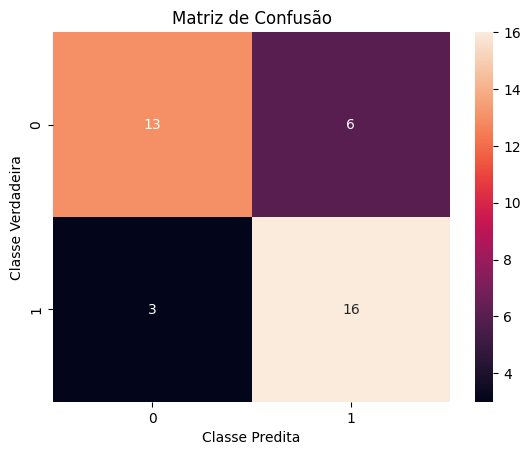

Accuracy --> 76.32%
Precision --> 72.73%
Recall --> 84.21%
F1 Score --> 78.05%
Classification Report  --> 
               precision    recall  f1-score   support

         0.0       0.81      0.68      0.74        19
         1.0       0.73      0.84      0.78        19

    accuracy                           0.76        38
   macro avg       0.77      0.76      0.76        38
weighted avg       0.77      0.76      0.76        38



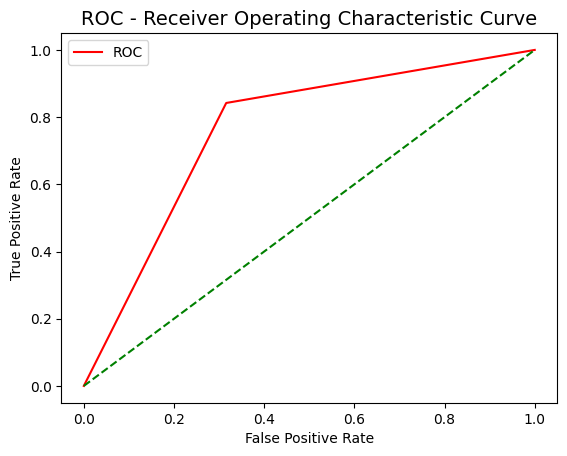

ROC AUC score --> 0.7632
Tempo de processamento do modelo: 0.530529260635376


TESTANDO O MODELO


Amostra selecionada:
         idade  hipertensao  cardiaco  tipo_trabalho  diabetes  status_fumo  \
580  0.278351          0.0       0.0            0.5       0.0          1.0   

     status_alcool  avc1  
580            1.0   0.0  
Resultado da amostra selecionada:
 580    0.0
Name: avc2, dtype: float64
Previsão do Algoritmo: 
 [0.]
Amostra selecionada:
         idade  hipertensao  cardiaco  tipo_trabalho  diabetes  status_fumo  \
347  0.896907          1.0       0.0            0.0       0.0          1.0   

     status_alcool  avc1  
347            0.5   1.0  
Resultado da amostra selecionada:
 347    1.0
Name: avc2, dtype: float64
Previsão do Algoritmo: 
 [1.]


In [ ]:
print('DECISION TREE CLASSIFIER')

dtc=DecisionTreeClassifier(criterion='entropy',max_depth=20)
print('\n')

print('========================')
print('VALIDAÇÃO CRUZADA')
print('========================')
print('\n')

startdtc_cv = time.time()
for score in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
#  print(score)
  scr = score
  mscr = scr.upper()
#  print(Mscr)
  cv = StratifiedKFold(n_splits = 5, shuffle = True)
  results = cross_val_score(dtc, train_x, train_y, cv = 5, scoring=score)
  cross(results,mscr)
#std_dtc = np.std(results)
#mean_dtc = np.mean(results)
#print("Acurácias para cada fold: {}".format(results))
#print('Média AUC-ROC:', mean_dtc)
#print("Desvio padrão da acurácia: {:.2f}".format(std_dtc))
#intervalo(results)
enddtc_cv = time.time()
print('Tempo de processamento do modelo para a validação cruzada:', enddtc_cv-startdtc_cv)
print('\n')

print('========================')
print('MODELO REAL')
print('========================')
print('\n')

startdtc = time.time()
dtc.fit(train_x,train_y)
predict_dtc=dtc.predict(test_x)
predict_prob_dtc = dtc.predict_proba(test_x)[:,1]

cm_dtc = confusion_matrix(test_y, predict_dtc)
heatmap = sns.heatmap(cm_dtc, annot=True, fmt='d')
heatmap.set_title('Matriz de Confusão')
heatmap.set_xlabel('Classe Predita')
heatmap.set_ylabel('Classe Verdadeira')
plt.show()

#cm_dtc = confusion_matrix(test_y, predict_dtc, labels=dtc.classes_)
#disp_dtc = ConfusionMatrixDisplay(confusion_matrix=cm_dtc,display_labels=dtc.classes_)
#disp_dtc.plot()
#plt.show()

fper_dtc, tper_dtc, thresholds = roc_curve(test_y, predict_prob_dtc)

print('Accuracy --> {:.4}%' .format(accuracy_score(test_y,predict_dtc)*100))
#print('Accuracy --> ',accuracy_score(test_y,predict_dtc))

print('Precision --> {:.4}%' .format(precision_score(test_y,predict_dtc)*100))
##print('Recall --> ',recall_score(y_test,predict_dtc))

print('Recall --> {:.4}%' .format(recall_score(test_y,predict_dtc)*100))
##print('Recall --> ',recall_score(y_test,predict_dtc))

print('F1 Score --> {:.4}%' .format(f1_score(test_y,predict_dtc)*100))
##print('F1 Score --> ',f1_score(test_y,predict_dtc))

print('Classification Report  --> \n',classification_report(test_y,predict_dtc))

plot_roc_curve(fper_dtc, tper_dtc)
print('ROC AUC score --> {:.4}' .format(roc_auc_score(test_y,predict_prob_dtc)))

#desvio_padrao = np.std(test_y - predict_dtc)
#print(desvio_padrao)

#desvio_padrao1 = np.std(test_y)
#print(desvio_padrao1)

enddtc = time.time()
print('Tempo de processamento do modelo:', enddtc-startdtc)
print('\n')

print('========================')
print('TESTANDO O MODELO')
print('========================')
print('\n')

print("Amostra selecionada:\n", teste_x[50:51])
print("Resultado da amostra selecionada:\n", teste_y[50:51])

previsoesdoalgoritmoDTC=dtc.predict(teste_x[50:51])
print("Previsão do Algoritmo: \n", previsoesdoalgoritmoDTC)


print("Amostra selecionada:\n", teste_x[13:14])
print("Resultado da amostra selecionada:\n", teste_y[13:14])

previsoesdoalgoritmoDTC=dtc.predict(teste_x[13:14])
print("Previsão do Algoritmo: \n", previsoesdoalgoritmoDTC)


**KNN**

KNN


VALIDAÇÃO CRUZADA


Valor do ACCURACY para cada fold: [0.78571429 0.92307692 0.84615385 0.92307692 0.84615385]
Média ACCURACY 86.48%
Devio Padrão para ACCURACY : 0.0524


Valor do PRECISION para cada fold: [0.75       0.85714286 0.75       0.875      0.85714286]
Média PRECISION 81.79%
Devio Padrão para PRECISION : 0.0558


Valor do RECALL para cada fold: [0.85714286 1.         1.         1.         0.85714286]
Média RECALL 94.29%
Devio Padrão para RECALL : 0.0700


Valor do F1 para cada fold: [0.8        0.92307692 0.85714286 0.93333333 0.85714286]
Média F1 87.41%
Devio Padrão para F1 : 0.0489


Valor do ROC_AUC para cada fold: [0.85714286 0.9047619  0.9047619  0.88095238 0.83333333]
Média ROC_AUC 0.88
Devio Padrão para ROC_AUC : 0.0278


Tempo de processamento do modelo para a validação cruzada: 0.3695082664489746


MODELO REAL




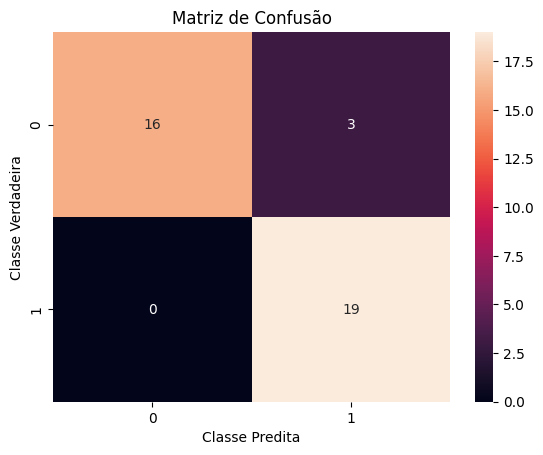

Accuracy --> 92.11%
Precision --> 86.36%
Recall --> 100.0%
F1 Score --> 92.68%
Classification Report  --> 
               precision    recall  f1-score   support

         0.0       1.00      0.84      0.91        19
         1.0       0.86      1.00      0.93        19

    accuracy                           0.92        38
   macro avg       0.93      0.92      0.92        38
weighted avg       0.93      0.92      0.92        38



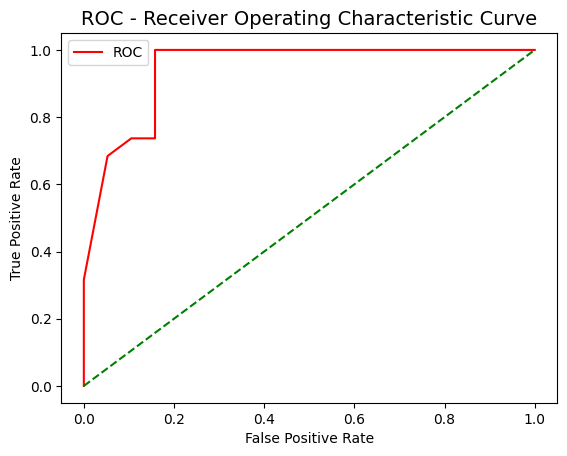

ROC AUC score --> 0.9446
Tempo de processamento do modelo: 0.529303789138794


TESTANDO O MODELO


Amostra selecionada:
         idade  hipertensao  cardiaco  tipo_trabalho  diabetes  status_fumo  \
580  0.278351          0.0       0.0            0.5       0.0          1.0   

     status_alcool  avc1  
580            1.0   0.0  
Resultado da amostra selecionada:
 580    0.0
Name: avc2, dtype: float64
Previsão do Algoritmo: 
 [0.]
Amostra selecionada:
         idade  hipertensao  cardiaco  tipo_trabalho  diabetes  status_fumo  \
347  0.896907          1.0       0.0            0.0       0.0          1.0   

     status_alcool  avc1  
347            0.5   1.0  
Resultado da amostra selecionada:
 347    1.0
Name: avc2, dtype: float64
Previsão do Algoritmo: 
 [1.]


In [ ]:
print('KNN')

knn = KNeighborsClassifier(n_neighbors=30) # P/ undersampling e oversampling
#knn = KNeighborsClassifier(n_neighbors=100) #aplicar apenas para oversampling
print('\n')

print('========================')
print('VALIDAÇÃO CRUZADA')
print('========================')
print('\n')

startknn_cv = time.time()
#SEED = 42
#np.random.seed(SEED)
for score in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
  scr = score
  mscr = scr.upper()
  cv = StratifiedKFold(n_splits = 5, shuffle = True)
  results = cross_val_score(knn, train_x, train_y, cv = 5, scoring=score)
  cross(results,mscr)
endknn_cv = time.time()
print('Tempo de processamento do modelo para a validação cruzada:', endknn_cv-startknn_cv)
print('\n')

print('========================')
print('MODELO REAL')
print('========================')
print('\n')

startknn = time.time()
knn.fit(train_x,train_y)
predict_knn=knn.predict(test_x)
predict_prob_knn = knn.predict_proba(test_x)[:,1]

cm_knn = confusion_matrix(test_y, predict_knn)
heatmap = sns.heatmap(cm_knn, annot=True, fmt='d')
heatmap.set_title('Matriz de Confusão')
heatmap.set_xlabel('Classe Predita')
heatmap.set_ylabel('Classe Verdadeira')
plt.show()

#cm_knn = confusion_matrix(test_y, predict_knn, labels=knn.classes_)
#disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn,display_labels=knn.classes_)
#disp_knn.plot()
#plt.show()

fper_knn, tper_knn, thresholds = roc_curve(test_y, predict_prob_knn)

print('Accuracy --> {:.4}%' .format(accuracy_score(test_y,predict_knn)*100))

print('Precision --> {:.4}%' .format(precision_score(test_y,predict_knn)*100))

print('Recall --> {:.4}%' .format(recall_score(test_y,predict_knn)*100))

print('F1 Score --> {:.4}%' .format(f1_score(test_y,predict_knn)*100))

print('Classification Report  --> \n',classification_report(test_y,predict_knn))

plot_roc_curve(fper_knn, tper_knn)
print('ROC AUC score --> {:.4}' .format(roc_auc_score(test_y,predict_prob_knn)))

endknn = time.time()
print('Tempo de processamento do modelo:', endknn-startknn)
print('\n')

print('========================')
print('TESTANDO O MODELO')
print('========================')
print('\n')

print("Amostra selecionada:\n", teste_x[50:51])
print("Resultado da amostra selecionada:\n", teste_y[50:51])

previsoesdoalgoritmoKNN=knn.predict(teste_x[50:51])
print("Previsão do Algoritmo: \n", previsoesdoalgoritmoKNN)

print("Amostra selecionada:\n", teste_x[13:14])
print("Resultado da amostra selecionada:\n", teste_y[13:14])

previsoesdoalgoritmoKNN=knn.predict(teste_x[13:14])
print("Previsão do Algoritmo: \n", previsoesdoalgoritmoKNN)


**Logistic Regression**

LOGISTIC REGRESSION


VALIDAÇÃO CRUZADA


Valor do ACCURACY para cada fold: [0.64285714 0.92307692 0.84615385 0.92307692 0.92307692]
Média ACCURACY 85.16%
Devio Padrão para ACCURACY : 0.1086


Valor do PRECISION para cada fold: [0.66666667 1.         0.75       0.875      0.875     ]
Média PRECISION 83.33%
Devio Padrão para PRECISION : 0.1149


Valor do RECALL para cada fold: [0.57142857 0.83333333 1.         1.         1.        ]
Média RECALL 88.10%
Devio Padrão para RECALL : 0.1677


Valor do F1 para cada fold: [0.61538462 0.90909091 0.85714286 0.93333333 0.93333333]
Média F1 84.97%
Devio Padrão para F1 : 0.1204


Valor do ROC_AUC para cada fold: [0.7755102  1.         0.9047619  0.97619048 0.9047619 ]
Média ROC_AUC 0.91
Devio Padrão para ROC_AUC : 0.0782


Tempo de processamento do modelo para a validação cruzada: 0.32026076316833496


MODELO REAL




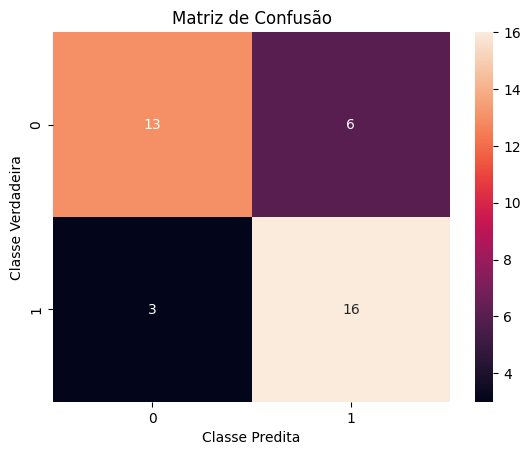

Accuracy --> 76.32%
Precision --> 72.73%
Recall --> 84.21%
F1 Score --> 78.05%
Classification Report  --> 
               precision    recall  f1-score   support

         0.0       0.81      0.68      0.74        19
         1.0       0.73      0.84      0.78        19

    accuracy                           0.76        38
   macro avg       0.77      0.76      0.76        38
weighted avg       0.77      0.76      0.76        38



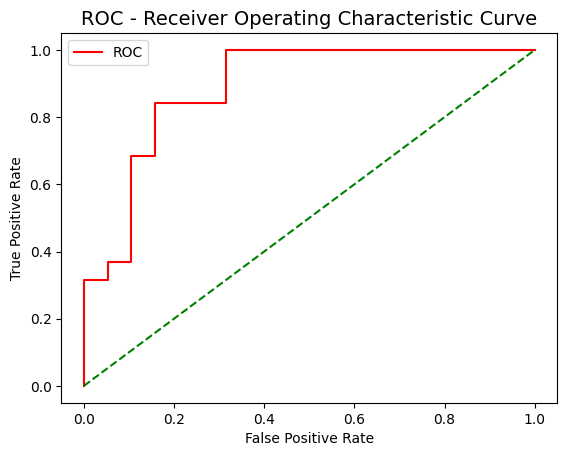

ROC AUC score --> 0.8892
Tempo de processamento do modelo: 0.5410959720611572


TESTANDO O MODELO


Amostra selecionada:
         idade  hipertensao  cardiaco  tipo_trabalho  diabetes  status_fumo  \
580  0.278351          0.0       0.0            0.5       0.0          1.0   

     status_alcool  avc1  
580            1.0   0.0  
Resultado da amostra selecionada:
 580    0.0
Name: avc2, dtype: float64
Previsão do Algoritmo: 
 [0.]
Amostra selecionada:
         idade  hipertensao  cardiaco  tipo_trabalho  diabetes  status_fumo  \
347  0.896907          1.0       0.0            0.0       0.0          1.0   

     status_alcool  avc1  
347            0.5   1.0  
Resultado da amostra selecionada:
 347    1.0
Name: avc2, dtype: float64
Previsão do Algoritmo: 
 [1.]


In [ ]:
print('LOGISTIC REGRESSION')

#lor=LogisticRegression()
#lor=LogisticRegression(random_state=0,C=100000,n_jobs=-1)
#lor=LogisticRegression(random_state=0,C=1000,n_jobs=-1)
lor=LogisticRegression(random_state=1,C=500)
print('\n')

print('========================')
print('VALIDAÇÃO CRUZADA')
print('========================')
print('\n')

startlor_cv = time.time()
#SEED = 42
#np.random.seed(SEED)
for score in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
  scr = score
  mscr = scr.upper()
  cv = StratifiedKFold(n_splits = 5, shuffle = True)
  results = cross_val_score(lor, train_x, train_y, cv = 5, scoring=score)
  cross(results,mscr)
endlor_cv = time.time()
print('Tempo de processamento do modelo para a validação cruzada:', endlor_cv-startlor_cv)
print('\n')


print('========================')
print('MODELO REAL')
print('========================')
print('\n')

startlor = time.time()
lor.fit(train_x,train_y)
predict_lor=lor.predict(test_x)
predict_prob_lor = lor.predict_proba(test_x)[:,1]

cm_lor = confusion_matrix(test_y, predict_lor)
heatmap = sns.heatmap(cm_lor, annot=True, fmt='d')
heatmap.set_title('Matriz de Confusão')
heatmap.set_xlabel('Classe Predita')
heatmap.set_ylabel('Classe Verdadeira')
plt.show()

#cm_lor = confusion_matrix(test_y, predict_lor, labels=lor.classes_)
#disp_lor = ConfusionMatrixDisplay(confusion_matrix=cm_lor,display_labels=lor.classes_)
#disp_lor.plot()
#plt.show()

fper_lor, tper_lor, thresholds = roc_curve(test_y, predict_prob_lor)

print('Accuracy --> {:.4}%' .format(accuracy_score(test_y,predict_lor)*100))
#print('Accuracy --> ',accuracy_score(test_y,predict_lor))

print('Precision --> {:.4}%' .format(precision_score(test_y,predict_lor)*100))

print('Recall --> {:.4}%' .format(recall_score(test_y,predict_lor)*100))
##print('Recall --> ',recall_score(y_test,predict_lor))

print('F1 Score --> {:.4}%' .format(f1_score(test_y,predict_lor)*100))
#print('F1 Score --> ',f1_score(test_y,predict_lor))

print('Classification Report  --> \n',classification_report(test_y,predict_lor))

plot_roc_curve(fper_lor, tper_lor)
print('ROC AUC score --> {:.4}' .format(roc_auc_score(test_y,predict_prob_lor)))

endlor = time.time()
print('Tempo de processamento do modelo:', endlor-startlor)
print('\n')

print('========================')
print('TESTANDO O MODELO')
print('========================')
print('\n')

print("Amostra selecionada:\n", teste_x[50:51])
print("Resultado da amostra selecionada:\n", teste_y[50:51])

previsoesdoalgoritmoLOR=lor.predict(teste_x[50:51])
print("Previsão do Algoritmo: \n", previsoesdoalgoritmoLOR)

print("Amostra selecionada:\n", teste_x[13:14])
print("Resultado da amostra selecionada:\n", teste_y[13:14])

previsoesdoalgoritmoLOR=lor.predict(teste_x[13:14])
print("Previsão do Algoritmo: \n", previsoesdoalgoritmoLOR)



**Naive Bayes**

NAIVE BAYES


VALIDAÇÃO CRUZADA


Valor do ACCURACY para cada fold: [0.85714286 0.92307692 0.84615385 0.92307692 0.92307692]
Média ACCURACY 89.45%
Devio Padrão para ACCURACY : 0.0352


Valor do PRECISION para cada fold: [0.77777778 0.85714286 0.75       0.875      0.875     ]
Média PRECISION 82.70%
Devio Padrão para PRECISION : 0.0527


Valor do RECALL para cada fold: [1. 1. 1. 1. 1.]
Média RECALL 100.00%
Devio Padrão para RECALL : 0.0000


Valor do F1 para cada fold: [0.875      0.92307692 0.85714286 0.93333333 0.93333333]
Média F1 90.44%
Devio Padrão para F1 : 0.0320


Valor do ROC_AUC para cada fold: [0.81632653 1.         0.85714286 0.85714286 0.92857143]
Média ROC_AUC 0.89
Devio Padrão para ROC_AUC : 0.0651


Tempo de processamento do modelo para a validação cruzada: 0.1870870590209961


MODELO REAL




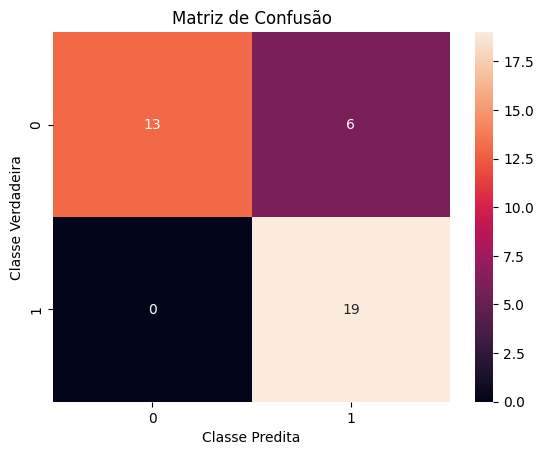

Accuracy --> 84.21%
Precision --> 76.0%
Recall --> 100.0%
F1 Score --> 86.36%
Classification Report  --> 
               precision    recall  f1-score   support

         0.0       1.00      0.68      0.81        19
         1.0       0.76      1.00      0.86        19

    accuracy                           0.84        38
   macro avg       0.88      0.84      0.84        38
weighted avg       0.88      0.84      0.84        38



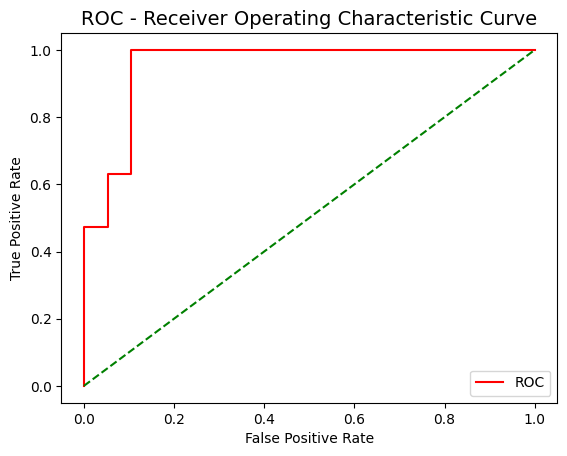

ROC AUC score --> 0.9529
Tempo de processamento do modelo: 0.521700382232666


Testando o modelo
Amostra selecionada:
         idade  hipertensao  cardiaco  tipo_trabalho  diabetes  status_fumo  \
580  0.278351          0.0       0.0            0.5       0.0          1.0   

     status_alcool  avc1  
580            1.0   0.0  
Resultado da amostra selecionada:
 580    0.0
Name: avc2, dtype: float64
Previsão do Algoritmo: 
 [0.]
Amostra selecionada:
         idade  hipertensao  cardiaco  tipo_trabalho  diabetes  status_fumo  \
347  0.896907          1.0       0.0            0.0       0.0          1.0   

     status_alcool  avc1  
347            0.5   1.0  
Resultado da amostra selecionada:
 347    1.0
Name: avc2, dtype: float64
Previsão do Algoritmo: 
 [1.]


In [ ]:
print('NAIVE BAYES')

gnb=GaussianNB()
print('\n')

print('========================')
print('VALIDAÇÃO CRUZADA')
print('========================')
print('\n')

startgnb_cv = time.time()
#SEED = 42
#np.random.seed(SEED)
for score in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
  scr = score
  mscr = scr.upper()
  cv = StratifiedKFold(n_splits = 5, shuffle = True)
  results = cross_val_score(gnb, train_x, train_y, cv = 5, scoring=score)
  cross(results,mscr)
endgnb_cv = time.time()
print('Tempo de processamento do modelo para a validação cruzada:', endgnb_cv-startgnb_cv)
print('\n')

print('========================')
print('MODELO REAL')
print('========================')
print('\n')

startgnb = time.time()
gnb.fit(train_x,train_y)
predict_gnb=gnb.predict(test_x)
predict_prob_gnb = gnb.predict_proba(test_x)[:,1]

cm_gnb = confusion_matrix(test_y, predict_gnb)
heatmap = sns.heatmap(cm_gnb, annot=True, fmt='d')
heatmap.set_title('Matriz de Confusão')
heatmap.set_xlabel('Classe Predita')
heatmap.set_ylabel('Classe Verdadeira')
plt.show()

#cm_gnb = confusion_matrix(test_y, predict_gnb, labels=gnb.classes_)
#disp_gnb = ConfusionMatrixDisplay(confusion_matrix=cm_gnb,display_labels=gnb.classes_)
#disp_gnb.plot()
#plt.show()

fper_gnb, tper_gnb, thresholds = roc_curve(test_y, predict_prob_gnb)

print('Accuracy --> {:.4}%' .format(accuracy_score(test_y,predict_gnb)*100))

print('Precision --> {:.4}%' .format(precision_score(test_y,predict_gnb)*100))

print('Recall --> {:.4}%' .format(recall_score(test_y,predict_gnb)*100))

print('F1 Score --> {:.4}%' .format(f1_score(test_y,predict_gnb)*100))

print('Classification Report  --> \n',classification_report(test_y,predict_gnb))

plot_roc_curve(fper_gnb, tper_gnb)
print('ROC AUC score --> {:.4}' .format(roc_auc_score(test_y,predict_prob_gnb)))

endgnb = time.time()
print('Tempo de processamento do modelo:', endgnb-startgnb)
print('\n')

print('========================')
print('========================')
print('Testando o modelo')

print("Amostra selecionada:\n", teste_x[50:51])
print("Resultado da amostra selecionada:\n", teste_y[50:51])

previsoesdoalgoritmoGNB=gnb.predict(teste_x[50:51])
print("Previsão do Algoritmo: \n", previsoesdoalgoritmoGNB)

print("Amostra selecionada:\n", teste_x[13:14])
print("Resultado da amostra selecionada:\n", teste_y[13:14])

previsoesdoalgoritmoGNB=gnb.predict(teste_x[13:14])
print("Previsão do Algoritmo: \n", previsoesdoalgoritmoGNB)


**SVM**

SVM


VALIDAÇÃO CRUZADA


Valor do ACCURACY para cada fold: [0.85714286 0.92307692 0.84615385 0.92307692 0.92307692]
Média ACCURACY 89.45%
Devio Padrão para ACCURACY : 0.0352


Valor do PRECISION para cada fold: [0.77777778 0.85714286 0.75       0.875      0.875     ]
Média PRECISION 82.70%
Devio Padrão para PRECISION : 0.0527


Valor do RECALL para cada fold: [1. 1. 1. 1. 1.]
Média RECALL 100.00%
Devio Padrão para RECALL : 0.0000


Valor do F1 para cada fold: [0.875      0.92307692 0.85714286 0.93333333 0.93333333]
Média F1 90.44%
Devio Padrão para F1 : 0.0320


Valor do ROC_AUC para cada fold: [0.79591837 1.         0.9047619  0.97619048 0.85714286]
Média ROC_AUC 0.91
Devio Padrão para ROC_AUC : 0.0752


Tempo de processamento do modelo para a validação cruzada: 0.18913817405700684


MODELO REAL




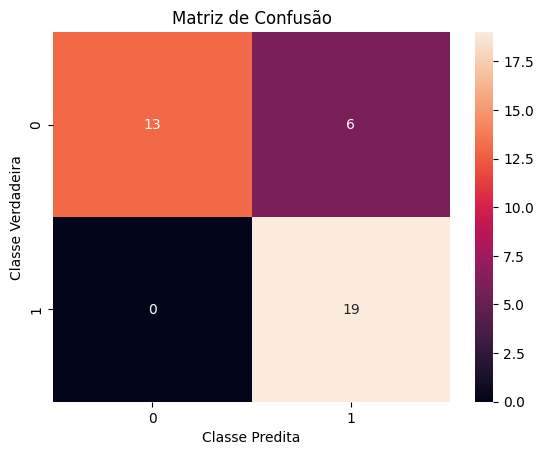

Accuracy --> 84.21%
Precision --> 76.0%
Recall --> 100.0%
F1 Score --> 86.36%
Classification Report  --> 
               precision    recall  f1-score   support

         0.0       1.00      0.68      0.81        19
         1.0       0.76      1.00      0.86        19

    accuracy                           0.84        38
   macro avg       0.88      0.84      0.84        38
weighted avg       0.88      0.84      0.84        38



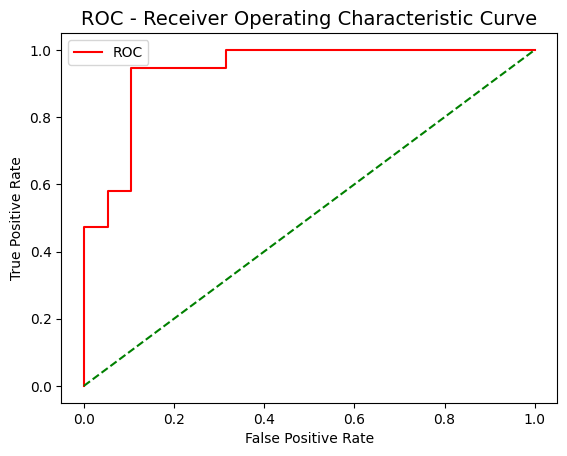

ROC AUC score --> 0.9391
Tempo de processamento do modelo: 0.5301389694213867


Testando o modelo
Amostra selecionada:
         idade  hipertensao  cardiaco  tipo_trabalho  diabetes  status_fumo  \
580  0.278351          0.0       0.0            0.5       0.0          1.0   

     status_alcool  avc1  
580            1.0   0.0  
Resultado da amostra selecionada:
 580    0.0
Name: avc2, dtype: float64
Previsão do Algoritmo: 
 [0.]
Amostra selecionada:
         idade  hipertensao  cardiaco  tipo_trabalho  diabetes  status_fumo  \
347  0.896907          1.0       0.0            0.0       0.0          1.0   

     status_alcool  avc1  
347            0.5   1.0  
Resultado da amostra selecionada:
 347    1.0
Name: avc2, dtype: float64
Previsão do Algoritmo: 
 [1.]


In [ ]:
print('SVM')

#startsvc = time.time()
#svc=SVC(probability=True)
#svc=SVC(random_state=0,C=100000)
#svc=SVC(random_state=0,C=100)
svc=SVC(kernel='linear',C=1,probability=True)
print('\n')

print('========================')
print('VALIDAÇÃO CRUZADA')
print('========================')
print('\n')

startsvc_cv = time.time()
#SEED = 42
#np.random.seed(SEED)
for score in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
  scr = score
  mscr = scr.upper()
  cv = StratifiedKFold(n_splits = 5, shuffle = True)
  results = cross_val_score(svc, train_x, train_y, cv = 5, scoring=score)
  cross(results,mscr)

endsvc_cv = time.time()
print('Tempo de processamento do modelo para a validação cruzada:', endsvc_cv-startsvc_cv)
print('\n')

print('========================')
print('MODELO REAL')
print('========================')
print('\n')

startsvc = time.time()
svc.fit(train_x,train_y)
predict_svc=svc.predict(test_x)
predict_prob_svc = svc.predict_proba(test_x)[:,1]

cm_svc = confusion_matrix(test_y, predict_svc)
heatmap = sns.heatmap(cm_svc, annot=True, fmt='d')
heatmap.set_title('Matriz de Confusão')
heatmap.set_xlabel('Classe Predita')
heatmap.set_ylabel('Classe Verdadeira')
plt.show()

#cm_svc = confusion_matrix(test_y, predict_svc, labels=svc.classes_)
#disp_svc = ConfusionMatrixDisplay(confusion_matrix=cm_svc,display_labels=svc.classes_)
#disp_svc.plot()
#plt.show()

fper_svc, tper_svc, thresholds = roc_curve(test_y, predict_prob_svc)

print('Accuracy --> {:.4}%' .format(accuracy_score(test_y,predict_svc)*100))
#print('Accuracy --> ',accuracy_score(predict_svc,test_y))

#print("Desvio Padrão: {:.2f}".format(np.std([accuracy_score(test_y,predict_svc)])))

print('Precision --> {:.4}%' .format(precision_score(test_y,predict_svc)*100))

print('Recall --> {:.4}%' .format(recall_score(test_y,predict_svc)*100))
##print('Recall --> ',recall_score(predict_dtc,test_y))

print('F1 Score --> {:.4}%' .format(f1_score(test_y,predict_svc)*100))
##print('F1 Score --> ',f1_score(predict_svc,test_y))

print('Classification Report  --> \n',classification_report(test_y,predict_svc))

plot_roc_curve(fper_svc, tper_svc)
print('ROC AUC score --> {:.4}' .format(roc_auc_score(test_y,predict_prob_svc)))

endsvc = time.time()
print('Tempo de processamento do modelo:', endsvc-startsvc)
print('\n')


print('========================')
print('========================')
print('Testando o modelo')


print("Amostra selecionada:\n", teste_x[50:51])
print("Resultado da amostra selecionada:\n", teste_y[50:51])

previsoesdoalgoritmoSVC=svc.predict(teste_x[50:51])
print("Previsão do Algoritmo: \n", previsoesdoalgoritmoSVC)

print("Amostra selecionada:\n", teste_x[13:14])
print("Resultado da amostra selecionada:\n", teste_y[13:14])

previsoesdoalgoritmoSVC=svc.predict(teste_x[13:14])
print("Previsão do Algoritmo: \n", previsoesdoalgoritmoSVC)


**Cat Boost Classifier**

CATBOOST CLASSIFIER


VALIDAÇÃO CRUZADA


Valor do ACCURACY para cada fold: [0.85714286 1.         0.61538462 0.92307692 0.84615385]
Média ACCURACY 84.84%
Devio Padrão para ACCURACY : 0.1288


Valor do PRECISION para cada fold: [0.85714286 1.         0.6        0.875      0.85714286]
Média PRECISION 83.79%
Devio Padrão para PRECISION : 0.1304


Valor do RECALL para cada fold: [0.85714286 1.         0.5        1.         0.85714286]
Média RECALL 84.29%
Devio Padrão para RECALL : 0.1829


Valor do F1 para cada fold: [0.85714286 1.         0.54545455 0.93333333 0.85714286]
Média F1 83.86%
Devio Padrão para F1 : 0.1560


Valor do ROC_AUC para cada fold: [0.89795918 1.         0.78571429 0.85714286 0.97619048]
Média ROC_AUC 0.90
Devio Padrão para ROC_AUC : 0.0783


Tempo de processamento do modelo para a validação cruzada: 30.2258038520813


MODELO REAL




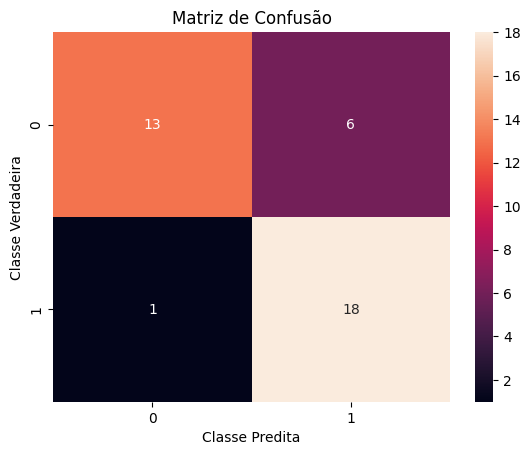

Accuracy --> 81.58%
Precision --> 75.0%
Recall --> 94.74%
F1 Score --> 83.72%
Classification Report  --> 
               precision    recall  f1-score   support

         0.0       0.93      0.68      0.79        19
         1.0       0.75      0.95      0.84        19

    accuracy                           0.82        38
   macro avg       0.84      0.82      0.81        38
weighted avg       0.84      0.82      0.81        38



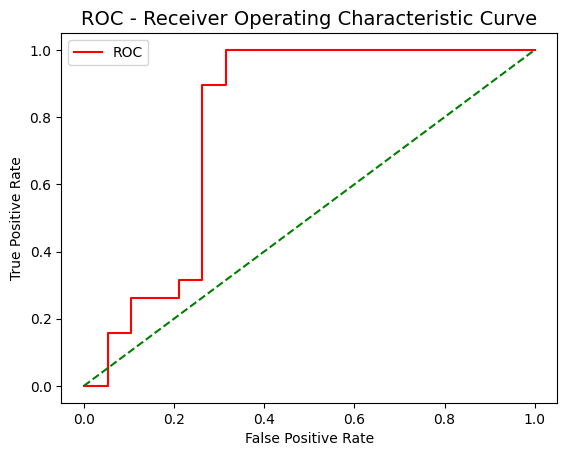

ROC AUC score --> 0.7839
Tempo de processamento do modelo: 2.0587377548217773


TESTANDO O MODELO


Amostra selecionada:
         idade  hipertensao  cardiaco  tipo_trabalho  diabetes  status_fumo  \
580  0.278351          0.0       0.0            0.5       0.0          1.0   

     status_alcool  avc1  
580            1.0   0.0  
Resultado da amostra selecionada:
 580    0.0
Name: avc2, dtype: float64
Previsão do Algoritmo: 
 [0.]
Amostra selecionada:
         idade  hipertensao  cardiaco  tipo_trabalho  diabetes  status_fumo  \
347  0.896907          1.0       0.0            0.0       0.0          1.0   

     status_alcool  avc1  
347            0.5   1.0  
Resultado da amostra selecionada:
 347    1.0
Name: avc2, dtype: float64
Previsão do Algoritmo: 
 [1.]


In [ ]:
print('CATBOOST CLASSIFIER')
#startcbc = time.time()
#cbc=CatBoostClassifier()
#cbc=CatBoostClassifier(verbose=0, n_estimators=1000)
cbc=CatBoostClassifier(verbose=0,n_estimators=2000,learning_rate=0.1)
print('\n')

print('========================')
print('VALIDAÇÃO CRUZADA')
print('========================')
print('\n')

startcbc_cv = time.time()
#SEED = 42
#np.random.seed(SEED)
for score in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
  scr = score
  mscr = scr.upper()
  cv = StratifiedKFold(n_splits = 5, shuffle = True)
  results = cross_val_score(cbc, train_x, train_y, cv = 5, scoring=score)
  cross(results,mscr)

endcbc_cv = time.time()
print('Tempo de processamento do modelo para a validação cruzada:', endcbc_cv-startcbc_cv)
print('\n')

print('========================')
print('MODELO REAL')
print('========================')
print('\n')

startcbc = time.time()
cbc.fit(train_x,train_y)
predict_cbc=cbc.predict(test_x)
predict_prob_cbc = cbc.predict_proba(test_x)[:,1]

cm_cbc = confusion_matrix(test_y, predict_cbc)
heatmap = sns.heatmap(cm_cbc, annot=True, fmt='d')
heatmap.set_title('Matriz de Confusão')
heatmap.set_xlabel('Classe Predita')
heatmap.set_ylabel('Classe Verdadeira')
plt.show()

#cm_cbc = confusion_matrix(test_y, predict_cbc, labels=cbc.classes_)
#disp_cbc = ConfusionMatrixDisplay(confusion_matrix=cm_cbc,display_labels=cbc.classes_)
#disp_cbc.plot()
#plt.show()

fper_cbc, tper_cbc, thresholds = roc_curve(test_y, predict_prob_cbc)

print('Accuracy --> {:.4}%' .format(accuracy_score(test_y,predict_cbc)*100))
#print('Accuracy --> ',accuracy_score(test_y,predict_lgbmc))

#print("Desvio Padrão: {:.2f}".format(np.std([accuracy_score(test_y,predict_cbc)])))

print('Precision --> {:.4}%' .format(precision_score(test_y,predict_cbc)*100))

print('Recall --> {:.4}%' .format(recall_score(test_y,predict_cbc)*100))
##print('Recall --> ',recall_score(y_test,predict_lgbmc))

print('F1 Score --> {:.4}%' .format(f1_score(test_y,predict_cbc)*100))
##print('F1 Score --> ',f1_score(test_y,predict_lgbmc))

print('Classification Report  --> \n',classification_report(test_y,predict_cbc))

plot_roc_curve(fper_cbc, tper_cbc)
print('ROC AUC score --> {:.4}' .format(roc_auc_score(test_y,predict_prob_cbc)))
##print(f'ROC AUC score: {roc_auc_score(test_y,predict_prob_lgbmc)}')

endcbc = time.time()
print('Tempo de processamento do modelo:', endcbc-startcbc)
print('\n')


print('========================')
print('TESTANDO O MODELO')
print('========================')
print('\n')

print("Amostra selecionada:\n", teste_x[50:51])
print("Resultado da amostra selecionada:\n", teste_y[50:51])

previsoesdoalgoritmoCBC=cbc.predict(teste_x[50:51])
print("Previsão do Algoritmo: \n", previsoesdoalgoritmoCBC)

print("Amostra selecionada:\n", teste_x[13:14])
print("Resultado da amostra selecionada:\n", teste_y[13:14])

previsoesdoalgoritmoCBC=cbc.predict(teste_x[13:14])
print("Previsão do Algoritmo: \n", previsoesdoalgoritmoCBC)



**LGBMClassifier**

LGBM CLASSIFIER


VALIDAÇÃO CRUZADA


Valor do ACCURACY para cada fold: [0.71428571 0.76923077 0.76923077 0.84615385 0.84615385]
Média ACCURACY 78.90%
Devio Padrão para ACCURACY : 0.0508


Valor do PRECISION para cada fold: [0.71428571 0.71428571 0.71428571 0.85714286 0.85714286]
Média PRECISION 77.14%
Devio Padrão para PRECISION : 0.0700


Valor do RECALL para cada fold: [0.71428571 0.83333333 0.83333333 0.85714286 0.85714286]
Média RECALL 81.90%
Devio Padrão para RECALL : 0.0535


Valor do F1 para cada fold: [0.71428571 0.76923077 0.76923077 0.85714286 0.85714286]
Média F1 79.34%
Devio Padrão para F1 : 0.0558


Valor do ROC_AUC para cada fold: [0.7755102  0.88095238 0.76190476 0.91666667 0.97619048]
Média ROC_AUC 0.86
Devio Padrão para ROC_AUC : 0.0823


Tempo de processamento do modelo para a validação cruzada: 1.1137101650238037


MODELO REAL




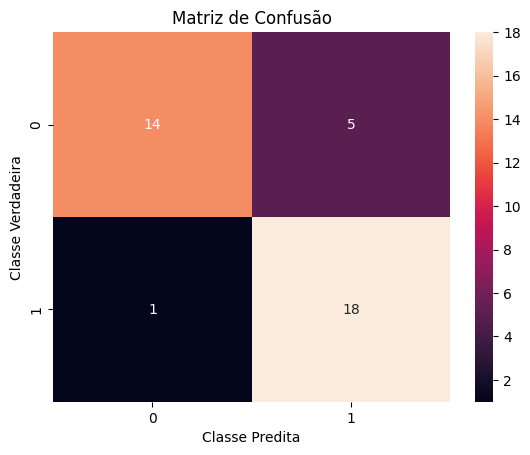

Accuracy --> 84.21%
Precision --> 78.26%
Recall --> 94.74%
F1 Score --> 85.71%
Classification Report  --> 
               precision    recall  f1-score   support

         0.0       0.93      0.74      0.82        19
         1.0       0.78      0.95      0.86        19

    accuracy                           0.84        38
   macro avg       0.86      0.84      0.84        38
weighted avg       0.86      0.84      0.84        38



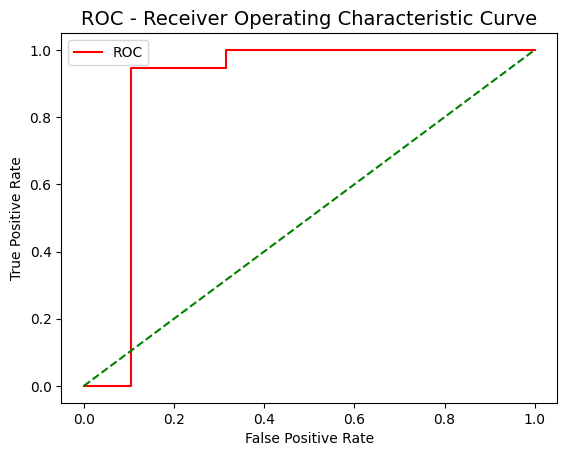

ROC AUC score --> 0.8837
Tempo de processamento do modelo: 0.7642383575439453


TESTANDO O MODELO


Amostra selecionada:
         idade  hipertensao  cardiaco  tipo_trabalho  diabetes  status_fumo  \
580  0.278351          0.0       0.0            0.5       0.0          1.0   

     status_alcool  avc1  
580            1.0   0.0  
Resultado da amostra selecionada:
 580    0.0
Name: avc2, dtype: float64
Previsão do Algoritmo: 
 [0.]
Amostra selecionada:
         idade  hipertensao  cardiaco  tipo_trabalho  diabetes  status_fumo  \
347  0.896907          1.0       0.0            0.0       0.0          1.0   

     status_alcool  avc1  
347            0.5   1.0  
Resultado da amostra selecionada:
 347    1.0
Name: avc2, dtype: float64
Previsão do Algoritmo: 
 [1.]


In [ ]:
print('LGBM CLASSIFIER')

#startlgbmc = time.time()
#lgbmc=LGBMClassifier()
#lgbmc=LGBMClassifier(n_estimators=2000,max_depth=5)
lgbmc=LGBMClassifier(n_estimators=500,max_depth=50)
print('\n')

print('========================')
print('VALIDAÇÃO CRUZADA')
print('========================')
print('\n')

startlgbmc_cv = time.time()
#SEED = 42
#np.random.seed(SEED)
for score in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
  scr = score
  mscr = scr.upper()
  cv = StratifiedKFold(n_splits = 5, shuffle = True)
  results = cross_val_score(lgbmc, train_x, train_y, cv = 5, scoring=score)
  cross(results,mscr)
endlgbmc_cv = time.time()
print('Tempo de processamento do modelo para a validação cruzada:', endlgbmc_cv-startlgbmc_cv)
print('\n')


print('========================')
print('MODELO REAL')
print('========================')
print('\n')

startlgbmc = time.time()
lgbmc.fit(train_x,train_y)
predict_lgbmc=lgbmc.predict(test_x)
predict_prob_lgbmc = lgbmc.predict_proba(test_x)[:,1]

cm_lgbmc = confusion_matrix(test_y, predict_lgbmc)
heatmap = sns.heatmap(cm_lgbmc, annot=True, fmt='d')
heatmap.set_title('Matriz de Confusão')
heatmap.set_xlabel('Classe Predita')
heatmap.set_ylabel('Classe Verdadeira')
plt.show()

#cm_lgbmc = confusion_matrix(test_y, predict_lgbmc, labels=lgbmc.classes_)
#disp_lgbmc = ConfusionMatrixDisplay(confusion_matrix=cm_lgbmc,display_labels=lgbmc.classes_)
#disp_lgbmc.plot()
#plt.show()

fper_lgbmc, tper_lgbmc, thresholds = roc_curve(test_y, predict_prob_lgbmc)

print('Accuracy --> {:.4}%' .format(accuracy_score(test_y,predict_lgbmc)*100))
#print('Accuracy --> ',accuracy_score(test_y,predict_lgbmc))

#print("Desvio Padrão: {:.2f}".format(np.std([accuracy_score(test_y,predict_lgbmc)])))

print('Precision --> {:.4}%' .format(precision_score(test_y,predict_lgbmc)*100))

print('Recall --> {:.4}%' .format(recall_score(test_y,predict_lgbmc)*100))
##print('Recall --> ',recall_score(y_test,predict_lgbmc))

print('F1 Score --> {:.4}%' .format(f1_score(test_y,predict_lgbmc)*100))
##print('F1 Score --> ',f1_score(test_y,predict_lgbmc))

print('Classification Report  --> \n',classification_report(test_y,predict_lgbmc))

plot_roc_curve(fper_lgbmc, tper_lgbmc)
print('ROC AUC score --> {:.4}' .format(roc_auc_score(test_y,predict_prob_lgbmc)))
##print(f'ROC AUC score: {roc_auc_score(test_y,predict_prob_lgbmc)}')

endlgbmc = time.time()
print('Tempo de processamento do modelo:', endlgbmc-startlgbmc)
print('\n')

print('========================')
print('TESTANDO O MODELO')
print('========================')
print('\n')

print("Amostra selecionada:\n", teste_x[50:51])
print("Resultado da amostra selecionada:\n", teste_y[50:51])

previsoesdoalgoritmoLGBMC=lgbmc.predict(teste_x[50:51])
print("Previsão do Algoritmo: \n", previsoesdoalgoritmoLGBMC)

print("Amostra selecionada:\n", teste_x[13:14])
print("Resultado da amostra selecionada:\n", teste_y[13:14])

previsoesdoalgoritmoLGBMC=lgbmc.predict(teste_x[13:14])
print("Previsão do Algoritmo: \n", previsoesdoalgoritmoLGBMC)


**Random** **Forest**

RANDOM FOREST


VALIDAÇÃO CRUZADA


Valor do ACCURACY para cada fold: [0.78571429 0.92307692 0.84615385 0.92307692 0.92307692]
Média ACCURACY 88.02%
Devio Padrão para ACCURACY : 0.0559


Valor do PRECISION para cada fold: [0.75       0.85714286 0.75       0.875      0.875     ]
Média PRECISION 82.14%
Devio Padrão para PRECISION : 0.0587


Valor do RECALL para cada fold: [0.85714286 1.         1.         1.         1.        ]
Média RECALL 97.14%
Devio Padrão para RECALL : 0.0571


Valor do F1 para cada fold: [0.8        0.92307692 0.85714286 0.93333333 0.93333333]
Média F1 88.94%
Devio Padrão para F1 : 0.0530


Valor do ROC_AUC para cada fold: [0.79591837 1.         0.88095238 0.89285714 0.95238095]
Média ROC_AUC 0.90
Devio Padrão para ROC_AUC : 0.0691


Tempo de processamento do modelo para a validação cruzada: 4.047005891799927


MODELO REAL




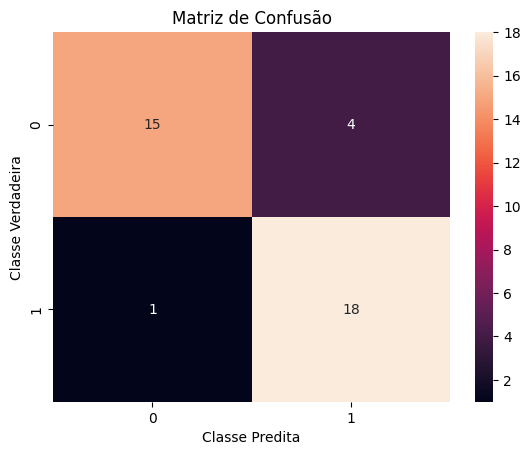

Accuracy --> 86.84%
Precision --> 81.82%
Recall --> 94.74%
F1 Score --> 87.8%
Classification Report  --> 
               precision    recall  f1-score   support

         0.0       0.94      0.79      0.86        19
         1.0       0.82      0.95      0.88        19

    accuracy                           0.87        38
   macro avg       0.88      0.87      0.87        38
weighted avg       0.88      0.87      0.87        38



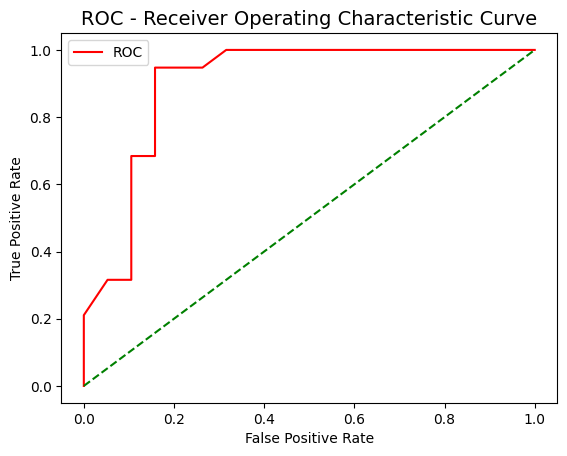

ROC AUC score --> 0.9017
Tempo de processamento do modelo: 0.6933512687683105


TESTANDO O MODELO


Amostra selecionada:
         idade  hipertensao  cardiaco  tipo_trabalho  diabetes  status_fumo  \
580  0.278351          0.0       0.0            0.5       0.0          1.0   

     status_alcool  avc1  
580            1.0   0.0  
Resultado da amostra selecionada:
 580    0.0
Name: avc2, dtype: float64
Previsão do Algoritmo: 
 [0.]
Amostra selecionada:
         idade  hipertensao  cardiaco  tipo_trabalho  diabetes  status_fumo  \
347  0.896907          1.0       0.0            0.0       0.0          1.0   

     status_alcool  avc1  
347            0.5   1.0  
Resultado da amostra selecionada:
 347    1.0
Name: avc2, dtype: float64
Previsão do Algoritmo: 
 [1.]


In [ ]:
print('RANDOM FOREST')
#startrf = time.time()
#rf=RandomForestClassifier()
#rf=RandomForestClassifier(criterion='gini',max_depth=5,n_estimators=100000,n_jobs=-1)
#rf=RandomForestClassifier(criterion='gini',max_depth=5,n_estimators=1000,n_jobs=-1)
#rf=RandomForestClassifier(random_state=1)
rf=RandomForestClassifier(criterion='entropy',n_estimators=100,random_state=1)
print('\n')

print('========================')
print('VALIDAÇÃO CRUZADA')
print('========================')
print('\n')

startrf_cv = time.time()
#SEED = 42
#np.random.seed(SEED)
for score in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
  scr = score
  mscr = scr.upper()
  cv = StratifiedKFold(n_splits = 5, shuffle = True)
  results = cross_val_score(rf, train_x, train_y, cv = 5, scoring=score)
  cross(results,mscr)
endrf_cv = time.time()
print('Tempo de processamento do modelo para a validação cruzada:', endrf_cv-startrf_cv)
print('\n')

print('========================')
print('MODELO REAL')
print('========================')
print('\n')

startrf = time.time()
rf.fit(train_x,train_y)
predict_rf=rf.predict(test_x)
predict_prob_rf = rf.predict_proba(test_x)[:,1]

cm_rf = confusion_matrix(test_y, predict_rf)
heatmap = sns.heatmap(cm_rf, annot=True, fmt='d')
heatmap.set_title('Matriz de Confusão')
heatmap.set_xlabel('Classe Predita')
heatmap.set_ylabel('Classe Verdadeira')
plt.show()

#cm_rf = confusion_matrix(test_y, predict_rf, labels=rf.classes_)
#disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf,display_labels=rf.classes_)
#disp_rf.plot()
#plt.show()

fper_rf, tper_rf, thresholds = roc_curve(test_y, predict_prob_rf)

print('Accuracy --> {:.4}%' .format(accuracy_score(test_y,predict_rf)*100))
#print('Accuracy --> ',accuracy_score(test_y,predict_rf))

print('Precision --> {:.4}%' .format(precision_score(test_y,predict_rf)*100))

print('Recall --> {:.4}%' .format(recall_score(test_y,predict_rf)*100))
##print('Recall --> ',recall_score(y_test,predict_rf))

print('F1 Score --> {:.4}%' .format(f1_score(test_y,predict_rf)*100))

print('Classification Report  --> \n',classification_report(test_y,predict_rf))

plot_roc_curve(fper_rf, tper_rf)
print('ROC AUC score --> {:.4}' .format(roc_auc_score(test_y,predict_prob_rf)))
##print(f'ROC AUC score: {roc_auc_score(test_y,predict_prob_rf)}')

endrf = time.time()
print('Tempo de processamento do modelo:', endrf-startrf)
print('\n')

print('========================')
print('TESTANDO O MODELO')
print('========================')
print('\n')

print("Amostra selecionada:\n", teste_x[50:51])
print("Resultado da amostra selecionada:\n", teste_y[50:51])

previsoesdoalgoritmoRF=rf.predict(teste_x[50:51])
print("Previsão do Algoritmo: \n", previsoesdoalgoritmoRF)

print("Amostra selecionada:\n", teste_x[13:14])
print("Resultado da amostra selecionada:\n", teste_y[13:14])

previsoesdoalgoritmoRF=rf.predict(teste_x[13:14])
print("Previsão do Algoritmo: \n", previsoesdoalgoritmoRF)


 **XGBClassifier**

XGB CLASSIFIER


VALIDAÇÃO CRUZADA


Valor do ACCURACY para cada fold: [0.71428571 1.         0.76923077 0.92307692 0.92307692]
Média ACCURACY 86.59%
Devio Padrão para ACCURACY : 0.1066


Valor do PRECISION para cada fold: [0.71428571 1.         0.71428571 0.875      0.875     ]
Média PRECISION 83.57%
Devio Padrão para PRECISION : 0.1091


Valor do RECALL para cada fold: [0.71428571 1.         0.83333333 1.         1.        ]
Média RECALL 90.95%
Devio Padrão para RECALL : 0.1170


Valor do F1 para cada fold: [0.71428571 1.         0.76923077 0.93333333 0.93333333]
Média F1 87.00%
Devio Padrão para F1 : 0.1089


Valor do ROC_AUC para cada fold: [0.79591837 1.         0.9047619  0.85714286 1.        ]
Média ROC_AUC 0.91
Devio Padrão para ROC_AUC : 0.0800


Tempo de processamento do modelo para a validação cruzada: 59.10562872886658


MODELO REAL




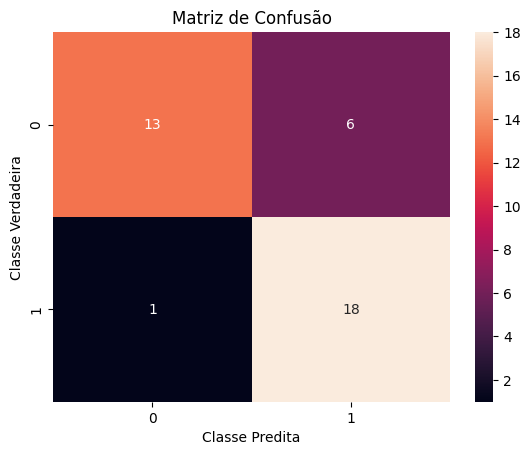

Accuracy --> 81.58%
Precision --> 75.0%
Recall --> 94.74%
F1 Score --> 83.72%
Classification Report  --> 
               precision    recall  f1-score   support

         0.0       0.93      0.68      0.79        19
         1.0       0.75      0.95      0.84        19

    accuracy                           0.82        38
   macro avg       0.84      0.82      0.81        38
weighted avg       0.84      0.82      0.81        38



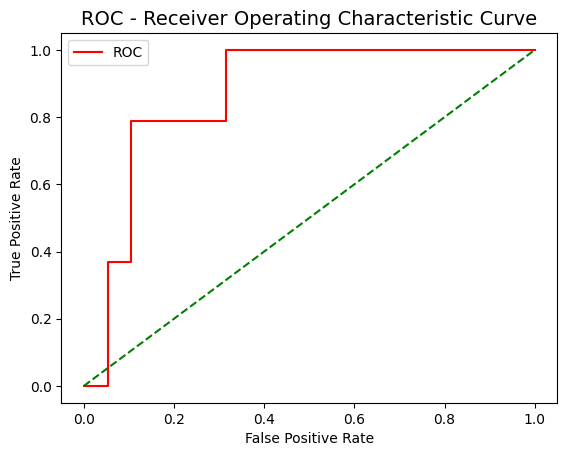

ROC AUC score --> 0.8698
Tempo de processamento do modelo: 2.6292524337768555


TESTANDO O MODELO


Amostra selecionada:
         idade  hipertensao  cardiaco  tipo_trabalho  diabetes  status_fumo  \
580  0.278351          0.0       0.0            0.5       0.0          1.0   

     status_alcool  avc1  
580            1.0   0.0  
Resultado da amostra selecionada:
 580    0.0
Name: avc2, dtype: float64
Previsão do Algoritmo: 
 [0]
Amostra selecionada:
         idade  hipertensao  cardiaco  tipo_trabalho  diabetes  status_fumo  \
347  0.896907          1.0       0.0            0.0       0.0          1.0   

     status_alcool  avc1  
347            0.5   1.0  
Resultado da amostra selecionada:
 347    1.0
Name: avc2, dtype: float64
Previsão do Algoritmo: 
 [1]


In [ ]:
print('XGB CLASSIFIER')

#startxgbc = time.time()
#xgbc=XGBClassifier()
#xgbc=XGBClassifier(objective='binary:logistic',n_estimators=100000,max_depth=5,learning_rate=0.001,n_jobs=-1)
#xgbc=XGBClassifier(objective='binary:logistic',n_estimators=400000,max_depth=5,learning_rate=0.001,n_jobs=-1)
#xgbc=XGBClassifier(objective='binary:logistic',n_estimators=1000,max_depth=5,learning_rate=0.0001,n_jobs=-1)
#xgbc=XGBClassifier(eval_metric='error',learning_rate= 0.1)
#xgbc=XGBClassifier(n_estimators=1000,learning_rate=0.001,max_depth=20)
xgbc=XGBClassifier(n_estimators=10000,learning_rate=0.001,max_depth=20)
print('\n')

print('========================')
print('VALIDAÇÃO CRUZADA')
print('========================')
print('\n')

startxgbc_cv = time.time()
#SEED = 42
#np.random.seed(SEED)
for score in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
  scr = score
  mscr = scr.upper()
  cv = StratifiedKFold(n_splits = 5, shuffle = True)
  results = cross_val_score(xgbc, train_x, train_y, cv = 5, scoring=score)
  cross(results,mscr)
endxgbc_cv = time.time()
print('Tempo de processamento do modelo para a validação cruzada:', endxgbc_cv-startxgbc_cv)
print('\n')

print('========================')
print('MODELO REAL')
print('========================')
print('\n')

startxgbc = time.time()
xgbc.fit(train_x,train_y)
predict_xgbc=xgbc.predict(test_x)
predict_prob_xgbc = xgbc.predict_proba(test_x)[:,1]

cm_xgbc = confusion_matrix(test_y, predict_xgbc)
heatmap = sns.heatmap(cm_xgbc, annot=True, fmt='d')
heatmap.set_title('Matriz de Confusão')
heatmap.set_xlabel('Classe Predita')
heatmap.set_ylabel('Classe Verdadeira')
plt.show()

#cm_xgbc = confusion_matrix(test_y, predict_xgbc, labels=xgbc.classes_)
#disp_xgbc = ConfusionMatrixDisplay(confusion_matrix=cm_xgbc,display_labels=xgbc.classes_)
#disp_xgbc.plot()
#plt.show()

fper_xgbc, tper_xgbc, thresholds = roc_curve(test_y, predict_prob_xgbc)

print('Accuracy --> {:.4}%' .format(accuracy_score(test_y,predict_xgbc)*100))
#print('Accuracy --> ',accuracy_score(test_y,predict_xgbc))

print('Precision --> {:.4}%' .format(precision_score(test_y,predict_xgbc)*100))

print('Recall --> {:.4}%' .format(recall_score(test_y,predict_xgbc)*100))
##print('Recall --> ',recall_score(y_test,predict_xgbc))

print('F1 Score --> {:.4}%' .format(f1_score(test_y,predict_xgbc)*100))
##print('F1 Score --> ',f1_score(test_y,predict_xgbc))

print('Classification Report  --> \n',classification_report(test_y,predict_xgbc))

plot_roc_curve(fper_xgbc, tper_xgbc)
print('ROC AUC score --> {:.4}' .format(roc_auc_score(test_y,predict_prob_xgbc)))
##print(f'ROC AUC score: {roc_auc_score(test_y,predict_prob_xgbc)}')

endxgbc = time.time()
print('Tempo de processamento do modelo:', endxgbc-startxgbc)
print('\n')

print('========================')
print('TESTANDO O MODELO')
print('========================')
print('\n')

print("Amostra selecionada:\n", teste_x[50:51])
print("Resultado da amostra selecionada:\n", teste_y[50:51])

previsoesdoalgoritmoXGBC=xgbc.predict(teste_x[50:51])
print("Previsão do Algoritmo: \n", previsoesdoalgoritmoXGBC)

print("Amostra selecionada:\n", teste_x[13:14])
print("Resultado da amostra selecionada:\n", teste_y[13:14])

previsoesdoalgoritmoXGBC=xgbc.predict(teste_x[13:14])
print("Previsão do Algoritmo: \n", previsoesdoalgoritmoXGBC)


**MLP**

MLP


VALIDAÇÃO CRUZADA


Valor do ACCURACY para cada fold: [0.71428571 0.92307692 0.84615385 0.92307692 0.92307692]
Média ACCURACY 86.59%
Devio Padrão para ACCURACY : 0.0815


Valor do PRECISION para cada fold: [0.66666667 1.         0.75       0.875      0.875     ]
Média PRECISION 83.33%
Devio Padrão para PRECISION : 0.1149


Valor do RECALL para cada fold: [0.71428571 0.83333333 1.         1.         1.        ]
Média RECALL 90.95%
Devio Padrão para RECALL : 0.1170


Valor do F1 para cada fold: [0.71428571 0.90909091 0.85714286 0.93333333 0.93333333]
Média F1 86.94%
Devio Padrão para F1 : 0.0824


Valor do ROC_AUC para cada fold: [0.81632653 1.         0.92857143 1.         1.        ]
Média ROC_AUC 0.95
Devio Padrão para ROC_AUC : 0.0719


Tempo de processamento do modelo para a validação cruzada: 13.45834231376648


MODELO REAL




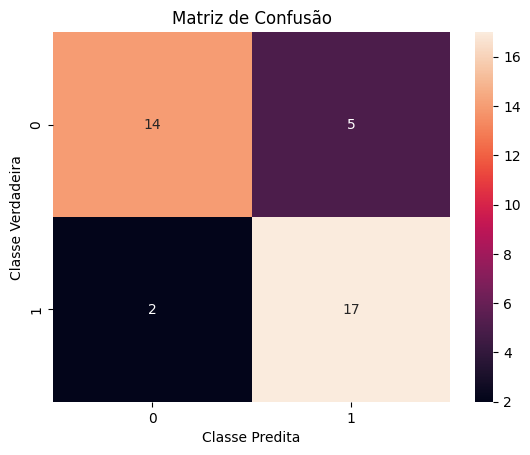

Accuracy --> 81.58%
Precision --> 77.27%
Recall --> 89.47%
F1 Score --> 82.93%
Classification Report  --> 
               precision    recall  f1-score   support

         0.0       0.88      0.74      0.80        19
         1.0       0.77      0.89      0.83        19

    accuracy                           0.82        38
   macro avg       0.82      0.82      0.81        38
weighted avg       0.82      0.82      0.81        38



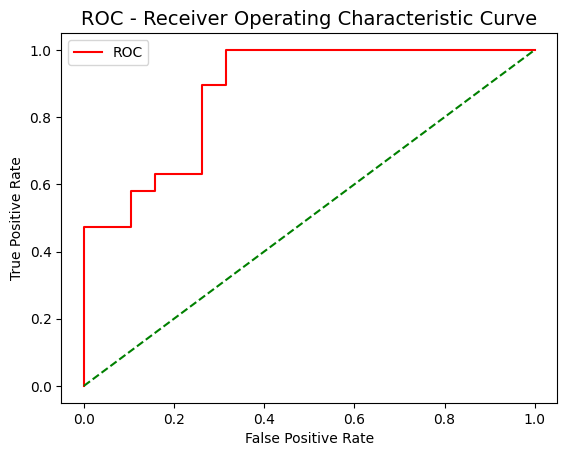

ROC AUC score --> 0.8781
Tempo de processamento do modelo: 1.3349378108978271


TESTANDO O MODELO


Amostra selecionada:
         idade  hipertensao  cardiaco  tipo_trabalho  diabetes  status_fumo  \
580  0.278351          0.0       0.0            0.5       0.0          1.0   

     status_alcool  avc1  
580            1.0   0.0  
Resultado da amostra selecionada:
 580    0.0
Name: avc2, dtype: float64
Previsão do Algoritmo: 
 [0.]
Amostra selecionada:
         idade  hipertensao  cardiaco  tipo_trabalho  diabetes  status_fumo  \
347  0.896907          1.0       0.0            0.0       0.0          1.0   

     status_alcool  avc1  
347            0.5   1.0  
Resultado da amostra selecionada:
 347    1.0
Name: avc2, dtype: float64
Previsão do Algoritmo: 
 [1.]


In [ ]:
print('MLP')

#startmlp = time.time()
#mlp = MLPClassifier()
#mlp = MLPClassifier(random_state=1)
mlp = MLPClassifier(learning_rate_init =0.001,max_iter=10000,hidden_layer_sizes=100)
print('\n')

print('========================')
print('VALIDAÇÃO CRUZADA')
print('========================')
print('\n')

startmlp_cv = time.time()
#SEED = 42
#np.random.seed(SEED)
for score in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
  scr = score
  mscr = scr.upper()
  cv = StratifiedKFold(n_splits = 5, shuffle = True)
  results = cross_val_score(mlp, train_x, train_y, cv = 5, scoring=score)
  cross(results,mscr)
endmlp_cv = time.time()
print('Tempo de processamento do modelo para a validação cruzada:', endmlp_cv-startmlp_cv)
print('\n')


print('========================')
print('MODELO REAL')
print('========================')
print('\n')

startmlp = time.time()
mlp.fit(train_x,train_y)
predict_mlp=mlp.predict(test_x)
predict_prob_mlp = mlp.predict_proba(test_x)[:,1]

cm_mlp = confusion_matrix(test_y, predict_mlp)
heatmap = sns.heatmap(cm_mlp, annot=True, fmt='d')
heatmap.set_title('Matriz de Confusão')
heatmap.set_xlabel('Classe Predita')
heatmap.set_ylabel('Classe Verdadeira')
plt.show()

#cm_mlp = confusion_matrix(test_y, predict_mlp, labels=mlp.classes_)
#disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp,display_labels=mlp.classes_)
#disp_mlp.plot()
#plt.show()

fper_mlp, tper_mlp, thresholds = roc_curve(test_y, predict_prob_mlp)

print('Accuracy --> {:.4}%' .format(accuracy_score(test_y,predict_mlp)*100))

print('Precision --> {:.4}%' .format(precision_score(test_y,predict_mlp)*100))

print('Recall --> {:.4}%' .format(recall_score(test_y,predict_mlp)*100))

print('F1 Score --> {:.4}%' .format(f1_score(test_y,predict_mlp)*100))

print('Classification Report  --> \n',classification_report(test_y,predict_mlp))

plot_roc_curve(fper_mlp, tper_mlp)
print('ROC AUC score --> {:.4}' .format(roc_auc_score(test_y,predict_prob_mlp)))

endmlp = time.time()
print('Tempo de processamento do modelo:', endmlp-startmlp)
print('\n')

print('========================')
print('TESTANDO O MODELO')
print('========================')
print('\n')

print("Amostra selecionada:\n", teste_x[50:51])
print("Resultado da amostra selecionada:\n", teste_y[50:51])

previsoesdoalgoritmoMLP=mlp.predict(teste_x[50:51])
print("Previsão do Algoritmo: \n", previsoesdoalgoritmoMLP)

print("Amostra selecionada:\n", teste_x[13:14])
print("Resultado da amostra selecionada:\n", teste_y[13:14])

previsoesdoalgoritmoMLP=mlp.predict(teste_x[13:14])
print("Previsão do Algoritmo: \n", previsoesdoalgoritmoMLP)


No conjunto de dados balanceado, contamos com a precisão, mas aqui temos um conjunto de dados desequilibrado, por isso devemos considerar a pontuação de AUC. Para um bom classificador, seria ótimo ter uma boa pontuação de precisão e recall. De todos os modelos, o LGBMClassifier tem um ótimo resultado. Portanto, como modelo, estou selecionando XGBClassifier.

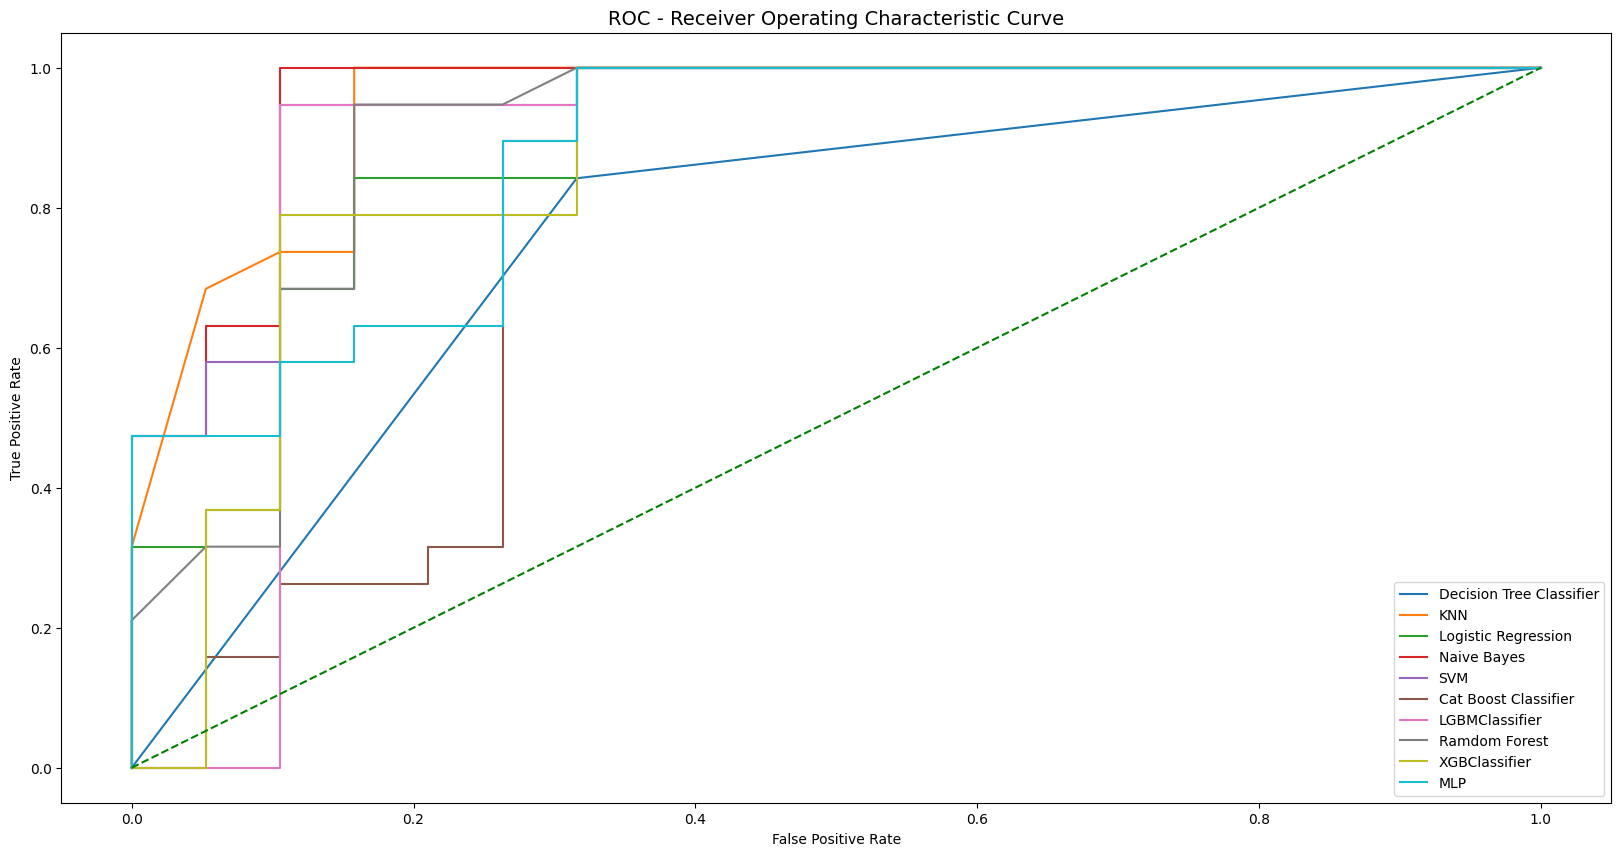

In [ ]:
fig, ax = plt.subplots(figsize = (20,10))
plt.plot(fper_dtc, tper_dtc, label='Decision Tree Classifier')
plt.plot(fper_knn, tper_knn, label='KNN')
plt.plot(fper_lor, tper_lor, label='Logistic Regression')
plt.plot(fper_gnb, tper_gnb, label='Naive Bayes')
plt.plot(fper_svc, tper_svc, label='SVM')
plt.plot(fper_cbc, tper_cbc, label='Cat Boost Classifier')
plt.plot(fper_lgbmc, tper_lgbmc, label='LGBMClassifier')
plt.plot(fper_rf, tper_rf, label='Ramdom Forest')
plt.plot(fper_xgbc, tper_xgbc, label='XGBClassifier')
plt.plot(fper_mlp, tper_mlp, label='MLP')

plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Receiver Operating Characteristic Curve', fontsize = 14)
plt.legend()
plt.show()

In [ ]:
print('==================================================')
print('=============== METODOS CLASSICOS ================')
print('==================================================')
print('\n')
print('DECISION TREE')
print('Accuracy --> {:.4}%' .format(accuracy_score(test_y,predict_dtc)*100))
print('Precision --> {:.4}%' .format(precision_score(test_y,predict_dtc)*100))
print('Recall --> {:.4}%' .format(recall_score(test_y,predict_dtc)*100))
print('F1 Score --> {:.4}%' .format(f1_score(test_y,predict_dtc)*100))
print('ROC AUC score --> {:.4}' .format(roc_auc_score(test_y,predict_prob_dtc)))
print('Tempo de processamento do modelo:', enddtc-startdtc)
print('\n')
print('==================================================')
print('KNN')
print('Accuracy --> {:.4}%' .format(accuracy_score(test_y,predict_knn)*100))
print('Precision --> {:.4}%' .format(precision_score(test_y,predict_knn)*100))
print('Recall --> {:.4}%' .format(recall_score(test_y,predict_knn)*100))
print('F1 Score --> {:.4}%' .format(f1_score(test_y,predict_knn)*100))
print('ROC AUC score --> {:.4}' .format(roc_auc_score(test_y,predict_prob_knn)))
print('Tempo de processamento do modelo:', endknn-startknn)
print('\n')
print('==================================================')
print('LOGISTIC REGRESSION')
print('Accuracy --> {:.4}%' .format(accuracy_score(test_y,predict_lor)*100))
print('Precision --> {:.4}%' .format(precision_score(test_y,predict_lor)*100))
print('Recall --> {:.4}%' .format(recall_score(test_y,predict_lor)*100))
print('F1 Score --> {:.4}%' .format(f1_score(test_y,predict_lor)*100))
print('ROC AUC score --> {:.4}' .format(roc_auc_score(test_y,predict_prob_lor)))
print('Tempo de processamento do modelo:', endlor-startlor)
print('\n')
print('==================================================')
print('NAIVE BAYES')
print('Accuracy --> {:.4}%' .format(accuracy_score(test_y,predict_gnb)*100))
print('Precision --> {:.4}%' .format(precision_score(test_y,predict_gnb)*100))
print('Recall --> {:.4}%' .format(recall_score(test_y,predict_gnb)*100))
print('F1 Score --> {:.4}%' .format(f1_score(test_y,predict_gnb)*100))
print('ROC AUC score --> {:.4}' .format(roc_auc_score(test_y,predict_prob_gnb)))
print('Tempo de processamento do modelo:', endgnb-startgnb)
print('\n')
print('==================================================')
print('SVM')
print('Accuracy --> {:.4}%' .format(accuracy_score(test_y,predict_svc)*100))
print('Precision --> {:.4}%' .format(precision_score(test_y,predict_svc)*100))
print('Recall --> {:.4}%' .format(recall_score(test_y,predict_svc)*100))
print('F1 Score --> {:.4}%' .format(f1_score(test_y,predict_svc)*100))
print('ROC AUC score --> {:.4}' .format(roc_auc_score(test_y,predict_prob_svc)))
print('Tempo de processamento do modelo:', endsvc-startsvc)
print('\n')
print('=================================================')
print('=============== METODOS ENSEMBLE ================')
print('=================================================')
print('\n')
print('==================================================')
print('CAT BOOST CLASSIFIER')
print('Accuracy --> {:.4}%' .format(accuracy_score(test_y,predict_cbc)*100))
print('Precision --> {:.4}%' .format(precision_score(test_y,predict_cbc)*100))
print('Recall --> {:.4}%' .format(recall_score(test_y,predict_cbc)*100))
print('F1 Score --> {:.4}%' .format(f1_score(test_y,predict_cbc)*100))
print('ROC AUC score --> {:.4}' .format(roc_auc_score(test_y,predict_prob_cbc)))
print('Tempo de processamento do modelo:', endcbc-startcbc)
print('\n')
print('==================================================')
print('LGBM CLASSIFIER')
print('Accuracy --> {:.4}%' .format(accuracy_score(test_y,predict_lgbmc)*100))
print('Precision --> {:.4}%' .format(precision_score(test_y,predict_lgbmc)*100))
print('Recall --> {:.4}%' .format(recall_score(test_y,predict_lgbmc)*100))
print('F1 Score --> {:.4}%' .format(f1_score(test_y,predict_lgbmc)*100))
print('ROC AUC score --> {:.4}' .format(roc_auc_score(test_y,predict_prob_lgbmc)))
print('Tempo de processamento do modelo:', endlgbmc-startlgbmc)
print('\n')
print('==================================================')
print('RANDOM FOREST')
print('Accuracy --> {:.4}%' .format(accuracy_score(test_y,predict_rf)*100))
print('Precision --> {:.4}%' .format(precision_score(test_y,predict_rf)*100))
print('Recall --> {:.4}%' .format(recall_score(test_y,predict_rf)*100))
print('F1 Score --> {:.4}%' .format(f1_score(test_y,predict_rf)*100))
print('ROC AUC score --> {:.4}' .format(roc_auc_score(test_y,predict_prob_rf)))
print('Tempo de processamento do modelo:', endrf-startrf)
print('\n')
print('==================================================')
print('XGBOOST CLASSIFIER')
print('Accuracy --> {:.4}%' .format(accuracy_score(test_y,predict_xgbc)*100))
print('Precision --> {:.4}%' .format(precision_score(test_y,predict_xgbc)*100))
print('Recall --> {:.4}%' .format(recall_score(test_y,predict_xgbc)*100))
print('F1 Score --> {:.4}%' .format(f1_score(test_y,predict_xgbc)*100))
print('ROC AUC score --> {:.4}' .format(roc_auc_score(test_y,predict_prob_xgbc)))
print('Tempo de processamento do modelo:', endxgbc-startxgbc)
print('\n')
print('=================================================')
print('=============== REDES NEURAIS ===================')
print('=================================================')
print('\n')
print('==================================================')
print('MLP')
print('Accuracy --> {:.4}%' .format(accuracy_score(test_y,predict_mlp)*100))
print('Precision --> {:.4}%' .format(precision_score(test_y,predict_mlp)*100))
print('Recall --> {:.4}%' .format(recall_score(test_y,predict_mlp)*100))
print('F1 Score --> {:.4}%' .format(f1_score(test_y,predict_mlp)*100))
print('ROC AUC score --> {:.4}' .format(roc_auc_score(test_y,predict_prob_mlp)))
print('Tempo de processamento do modelo:', endmlp-startmlp)
print('\n')
print('=================================================')

=============== METODOS CLASSICOS ================


DECISION TREE
Accuracy --> 76.32%
Precision --> 72.73%
Recall --> 84.21%
F1 Score --> 78.05%
ROC AUC score --> 0.7632
Tempo de processamento do modelo: 0.530529260635376


KNN
Accuracy --> 92.11%
Precision --> 86.36%
Recall --> 100.0%
F1 Score --> 92.68%
ROC AUC score --> 0.9446
Tempo de processamento do modelo: 0.529303789138794


LOGISTIC REGRESSION
Accuracy --> 76.32%
Precision --> 72.73%
Recall --> 84.21%
F1 Score --> 78.05%
ROC AUC score --> 0.8892
Tempo de processamento do modelo: 0.5410959720611572


NAIVE BAYES
Accuracy --> 84.21%
Precision --> 76.0%
Recall --> 100.0%
F1 Score --> 86.36%
ROC AUC score --> 0.9529
Tempo de processamento do modelo: 0.521700382232666


SVM
Accuracy --> 84.21%
Precision --> 76.0%
Recall --> 100.0%
F1 Score --> 86.36%
ROC AUC score --> 0.9391
Tempo de processamento do modelo: 0.5301389694213867


=============== METODOS ENSEMBLE ================


CAT BOOST CLASSIFIER
Accuracy --> 81.58%
Precision 

# **Fechamento**

Portanto, neste projeto, vimos alguns dos fatores que podem resultar em acidentes vasculares cerebrais. Onde a idade estava altamente correlacionada, seguida por hipertensão, doenças cardíacas, nível médio de glicose e já casado.

O Classificador XGB foi um método que teve um bom desempenho. Existem outliers em algumas variáveis, o motivo pelo qual mantive assim é porque essas coisas ou dependem de outros fatores e há possibilidades de haver esse tipo de registro.

Por exemplo, o IMC pode estar alto e ainda assim não haver AVC, pois a pessoa é jovem ou não tem nenhuma doença cardíaca.